In [1]:
#import standard libraries
import os
import warnings
import gc


#import datascience libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler




#import model 


pd.set_option('display.max_rows', None) 
warnings.filterwarnings(action = 'ignore')

In [2]:
#load datset
test_identity = pd.read_csv("../dataset/test_identity.csv")
test_transaction = pd.read_csv("../dataset/test_transaction.csv")

train_identity = pd.read_csv("../dataset/train_identity.csv")
train_transaction = pd.read_csv("../dataset/train_transaction.csv")


In [3]:
train_set = pd.merge(left=train_transaction,right=train_identity,how ='left', on = 'TransactionID')

In [4]:
%run DataPrepare.ipynb

In [5]:
#reduce the memory usage of train_set
Reduce_Memory_Usage(data = train_set)

origin memory usage: 1959.8762512207031
reduced memory usage: 650.4761695861816
memory reduce (66.8%)


In [6]:
del train_identity, train_transaction
gc.collect()

21

In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 650.5+ MB


#### Firstly, we need to identify the feature types of train_set

In [8]:
# 类别、离散特征
cate_col_list = ['ProductCD','P_emaildomain','R_emaildomain','DeviceType','DeviceInfo','addr1','addr2']

#循环加入特征
for i in range(1,7):
    cate_col_list.append('card' + str(i))
for i in range(1 ,10):
    cate_col_list.append('M' + str(i))
for i in range(12 ,39):
    cate_col_list.append('id_' + str(i // 10) + str(i % 10))
#连续型特征
continual_col_list = [x for x in train_set.columns if x not in cate_col_list]
continual_col_list.remove('isFraud')

Then,we should check the picture of dataset

eg: the shape, specified data, 

In [9]:
#check the whole dataus 
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 650.5+ MB


In [10]:
#show a part data of  train set
train_set.head(5).append(train_set.tail(5))

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,280.000000,W,15066,170.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#the shape of dataset
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 650.5+ MB


In [12]:
#the description of dataset
train_set.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,...,139369.0,4.511300e+04,139318.0,139261.0,5159.0,5169.000000,4747.000000,5132.0000,5163.00000,77586.0
mean,3.282270e+06,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,inf,inf,12.820312,inf,inf,NaN
std,1.704744e+05,0.183755,4.617224e+06,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,...,0.0,1.561523e+00,NaN,NaN,inf,6.898438,2.371094,97.4375,32.09375,0.0
min,2.987000e+06,0.000000,8.640000e+04,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,...,100.0,1.000000e+01,100.0,100.0,100.0,10.000000,11.000000,100.0000,100.00000,0.0
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,...,166.0,1.300000e+01,266.0,256.0,252.0,14.000000,11.000000,321.0000,119.00000,24.0
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,...,166.0,1.500000e+01,341.0,472.0,252.0,14.000000,11.000000,321.0000,149.00000,24.0
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,...,225.0,1.500000e+01,427.0,533.0,486.5,14.000000,15.000000,371.0000,169.00000,32.0
max,3.577539e+06,1.000000,1.581113e+07,31936.000000,18396.000000,600.0,231.0,237.0,540.0,102.0,...,229.0,2.900000e+01,671.0,661.0,854.0,44.000000,26.000000,548.0000,216.00000,32.0


we can find that there many null value is dataset, 

so next step is count the null value nums

In [13]:
#check whether there is duplicated rows in dataset
train_set.duplicated().sum()

0

In [14]:
#the shape of dataset
train_set.shape

(590540, 434)

In [15]:
%run EDA_utils.ipynb

### Understanding Variables

we need to check every variable in dataset

## ProductCD

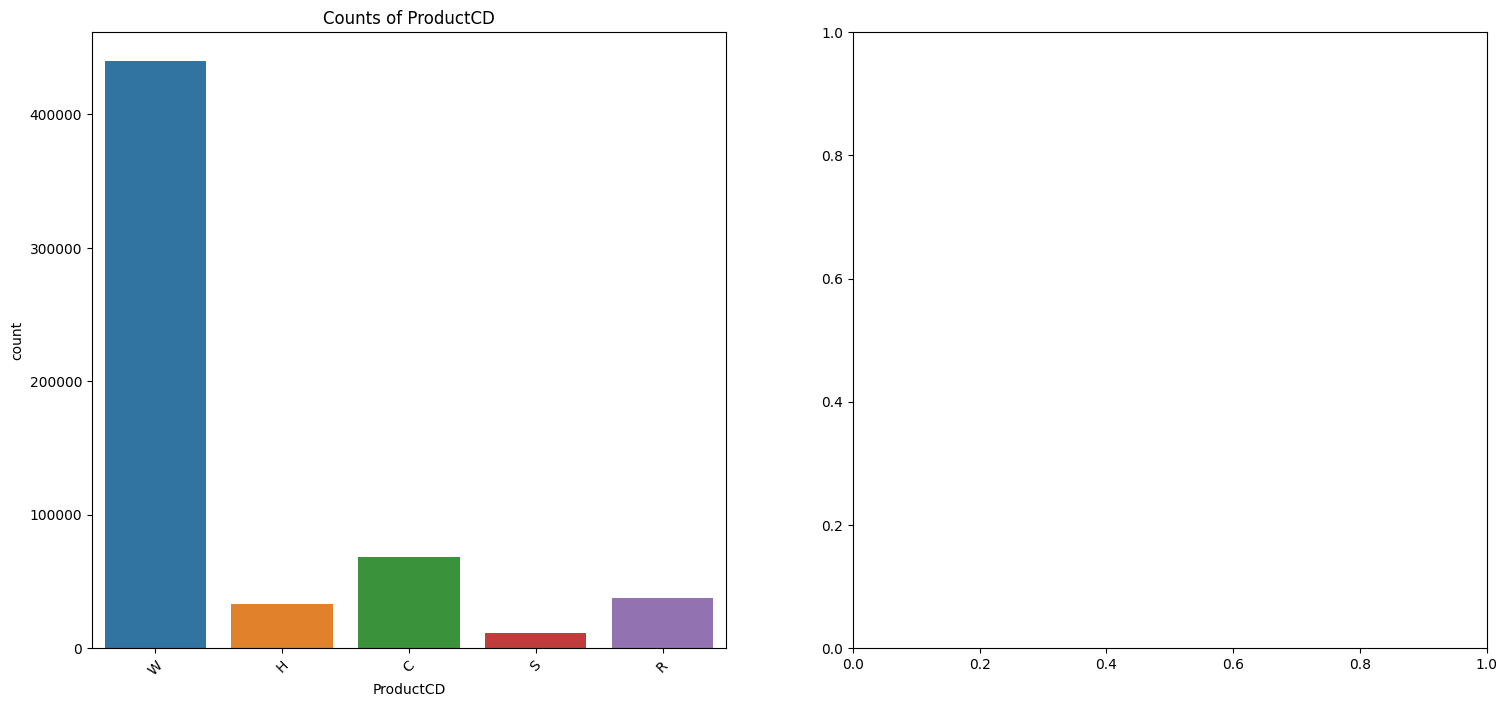

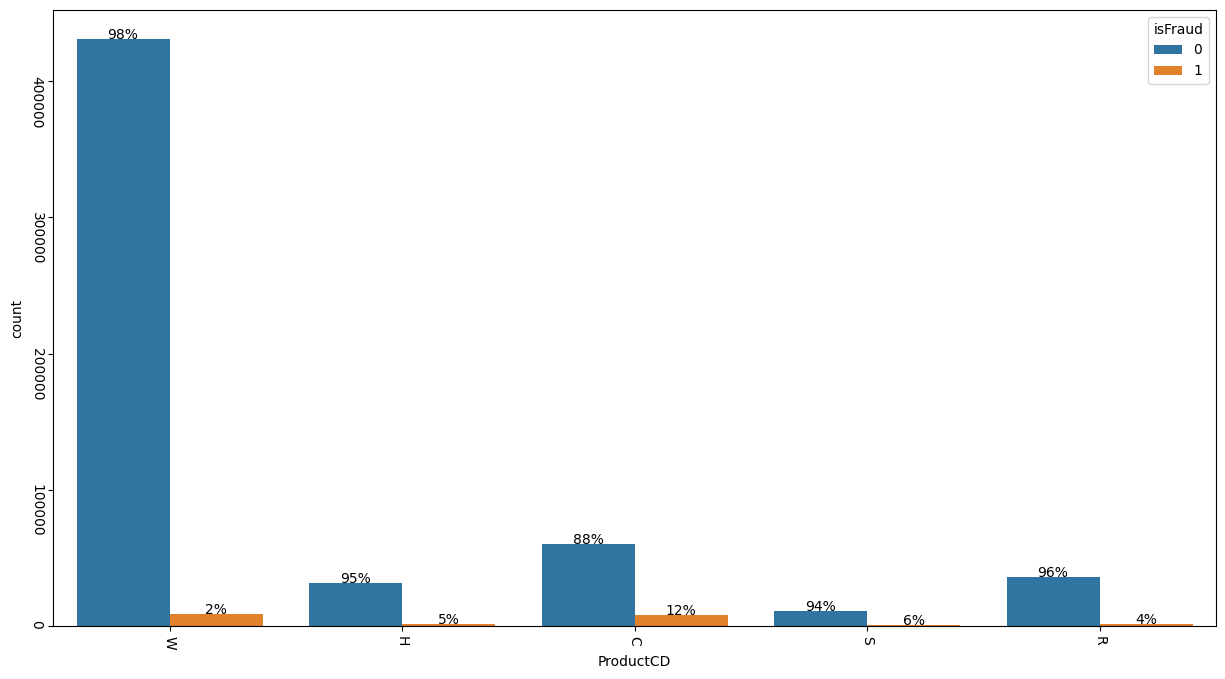

In [16]:
Plot_Cate_Feature(data = train_set, col = 'ProductCD')
train_set['ProductCD'].value_counts(normalize=True)

Plot_Cate_Correlation(train_set,col_A='ProductCD', col_B='isFraud', is_percentage=True)


### keypoint 1
we can confirm that 'w' is the common value,so we can speculate that product 'w' is the most popular

There are several rare value,such as 'H','S','R'

The value of label 'isFraud' taking percentage of different ProductCD value,
label '1' occupyes the most proportion in ProductCD 'C'

### keypoint 2
ProdcutCD 'W' is the most common value, but label '1' occupyes the least proportion.
<br>We need to find reasons for this phenomenon

## P_emaildomain
P_emaildomain is the domain of user email address

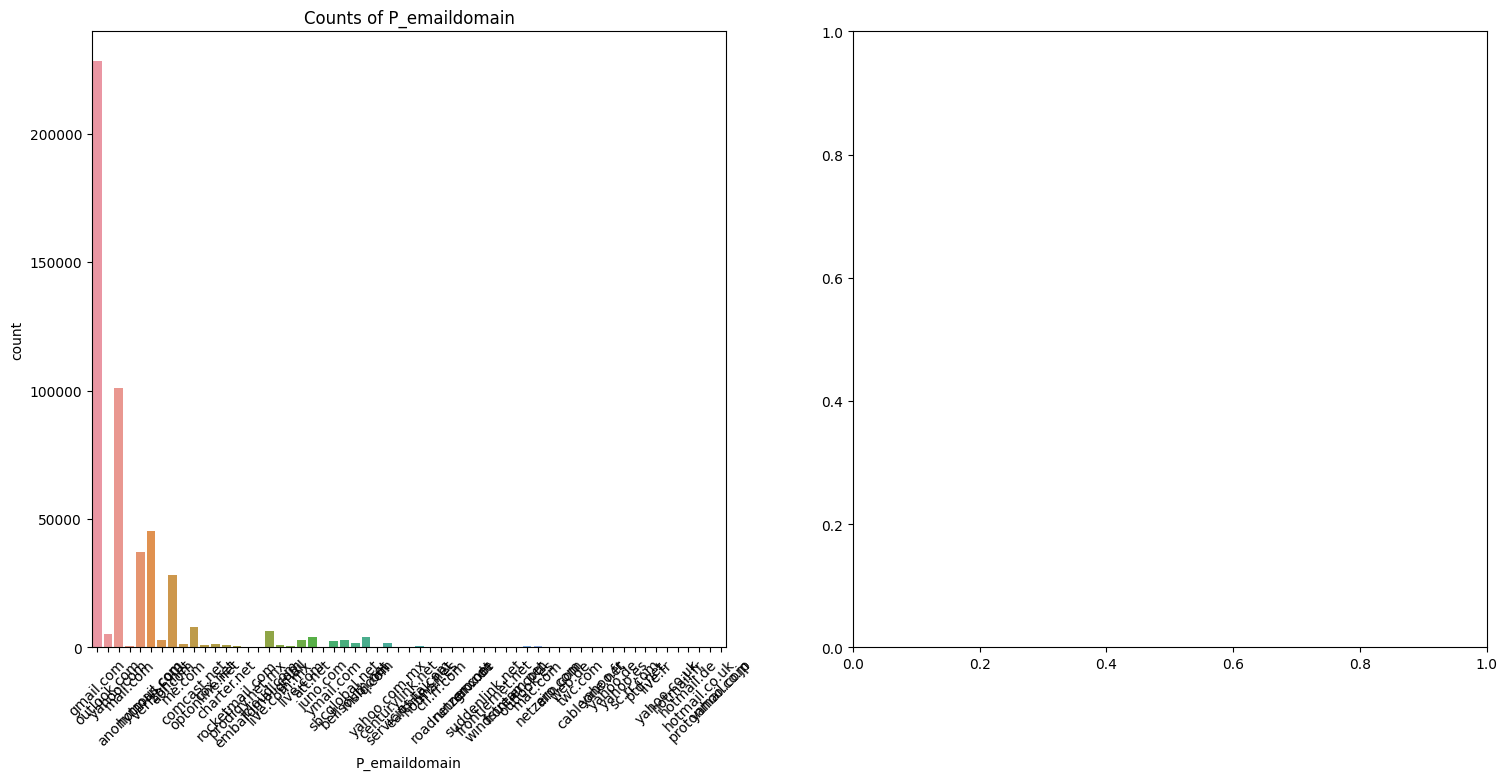

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

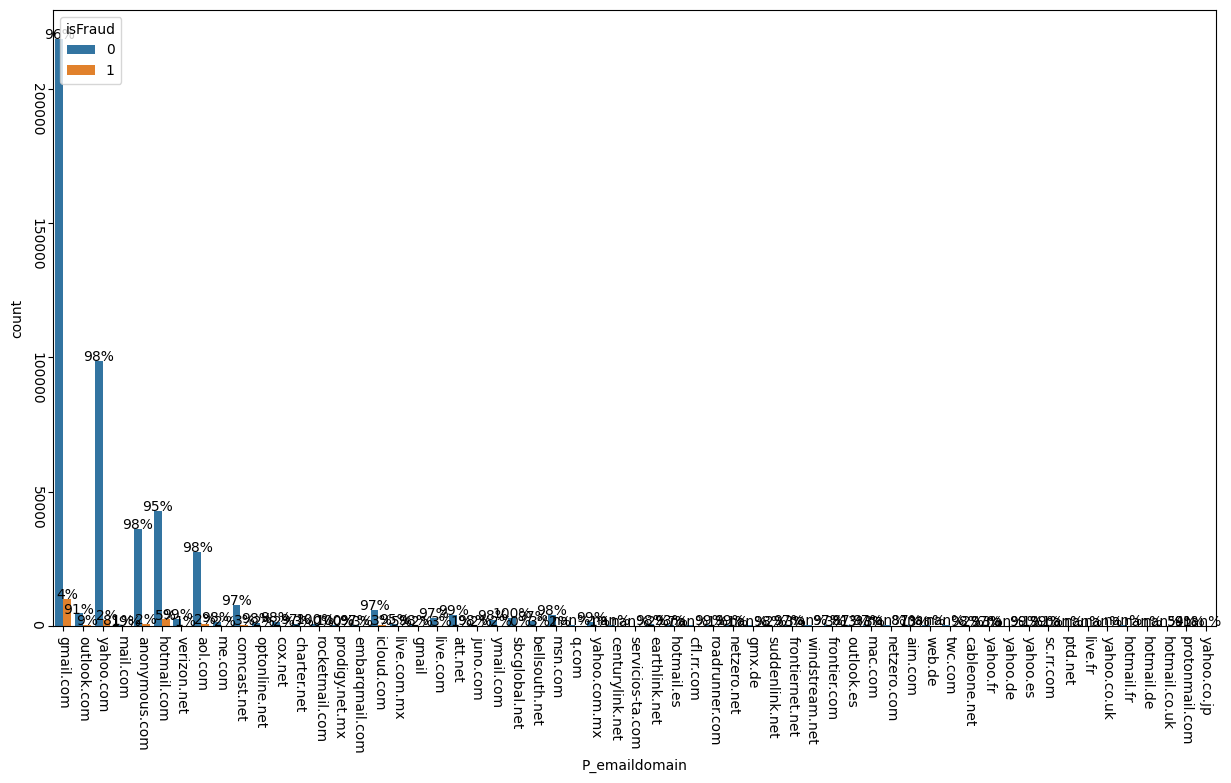

In [17]:
Plot_Cate_Feature(train_set, col = 'P_emaildomain')
train_set['P_emaildomain'].value_counts(normalize=True)
Plot_Cate_Correlation(train_set, col_A='P_emaildomain', col_B='isFraud', is_percentage=True)



### keypoint 1
we can see most user use gmail and yahoo as their daily email tool
<br> There are also many other email domain, so we must deal these rarely used email address
<br> After rare value handled, we can confirm the proportion of different email domain


### keypoint 2
Temporarily, we don't find the clear relationship between 'P_emaildomain' and 'isFraud'

## R_emaildomain

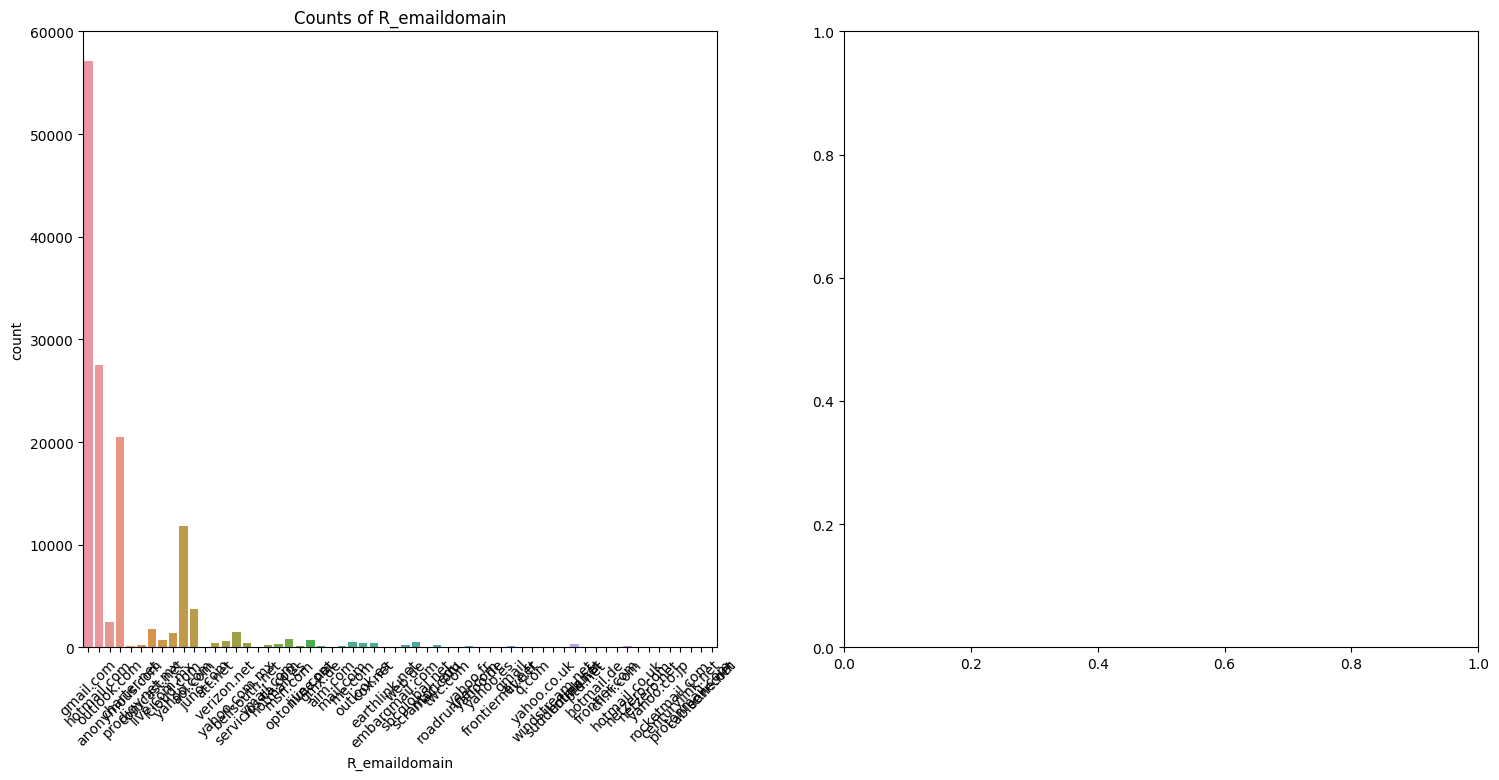

In [18]:
Plot_Cate_Feature(train_set, col = 'R_emaildomain')

In [19]:
train_set['R_emaildomain'].value_counts(normalize=True)

gmail.com           0.416247
hotmail.com         0.200370
anonymous.com       0.149529
yahoo.com           0.086255
aol.com             0.026957
outlook.com         0.018260
comcast.net         0.013198
yahoo.com.mx        0.010984
icloud.com          0.010183
msn.com             0.006206
live.com            0.005550
live.com.mx         0.005492
verizon.net         0.004516
me.com              0.004050
sbcglobal.net       0.004021
cox.net             0.003343
outlook.es          0.003154
att.net             0.003132
bellsouth.net       0.003074
hotmail.fr          0.002134
hotmail.es          0.002127
web.de              0.001726
mac.com             0.001588
ymail.com           0.001508
prodigy.net.mx      0.001508
optonline.net       0.001362
gmx.de              0.001071
yahoo.fr            0.000998
charter.net         0.000925
mail.com            0.000889
hotmail.co.uk       0.000765
gmail               0.000692
earthlink.net       0.000575
yahoo.de            0.000546
rocketmail.com

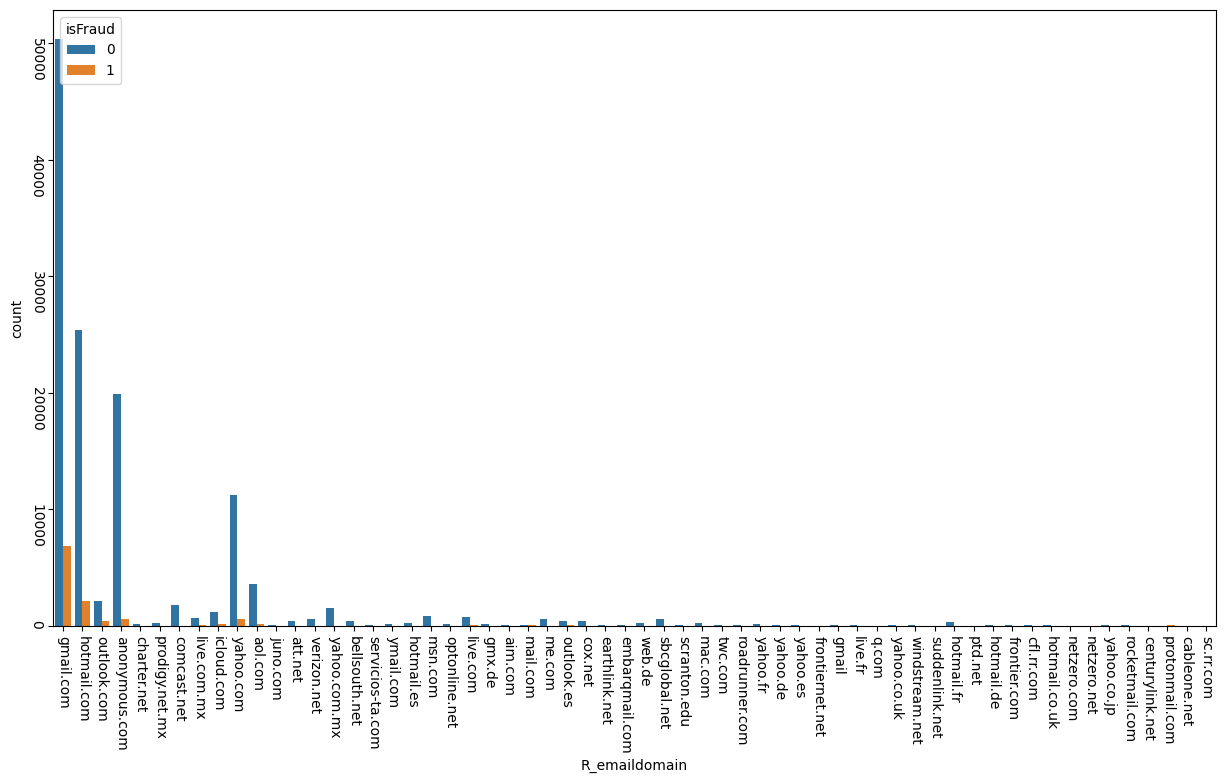

In [20]:
Plot_Cate_Correlation(train_set,col_A='R_emaildomain', col_B='isFraud')

### keypoint 1
the relaionship between R_emaildomain and P_emaildomain is not clear

### keypoint 2

the value counts of R_emaildomain is less than P_emaildomain <br>
so,we should find the difference beteen R_emaildomain and P_emaildomain

## DeviceType

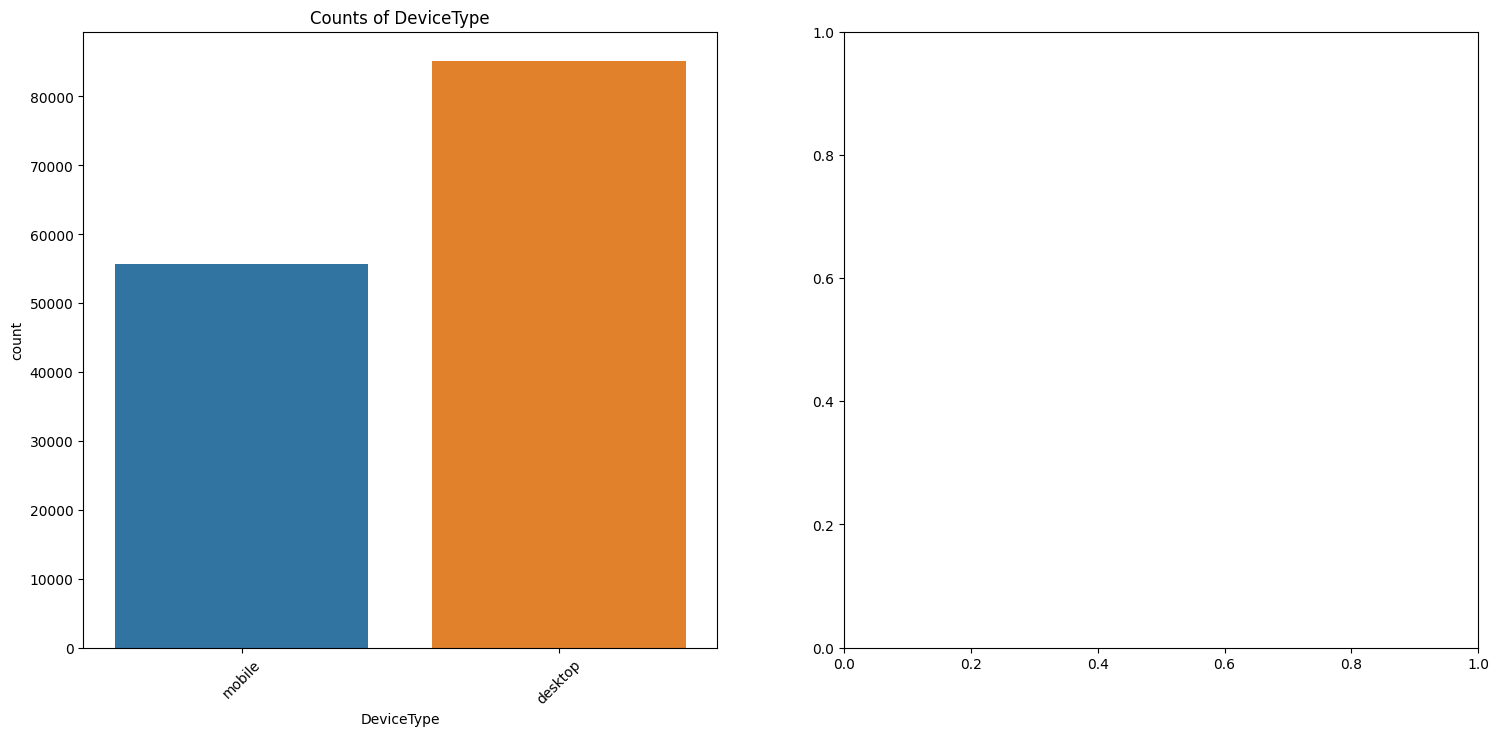

In [21]:
Plot_Cate_Feature(train_set,col='DeviceType')

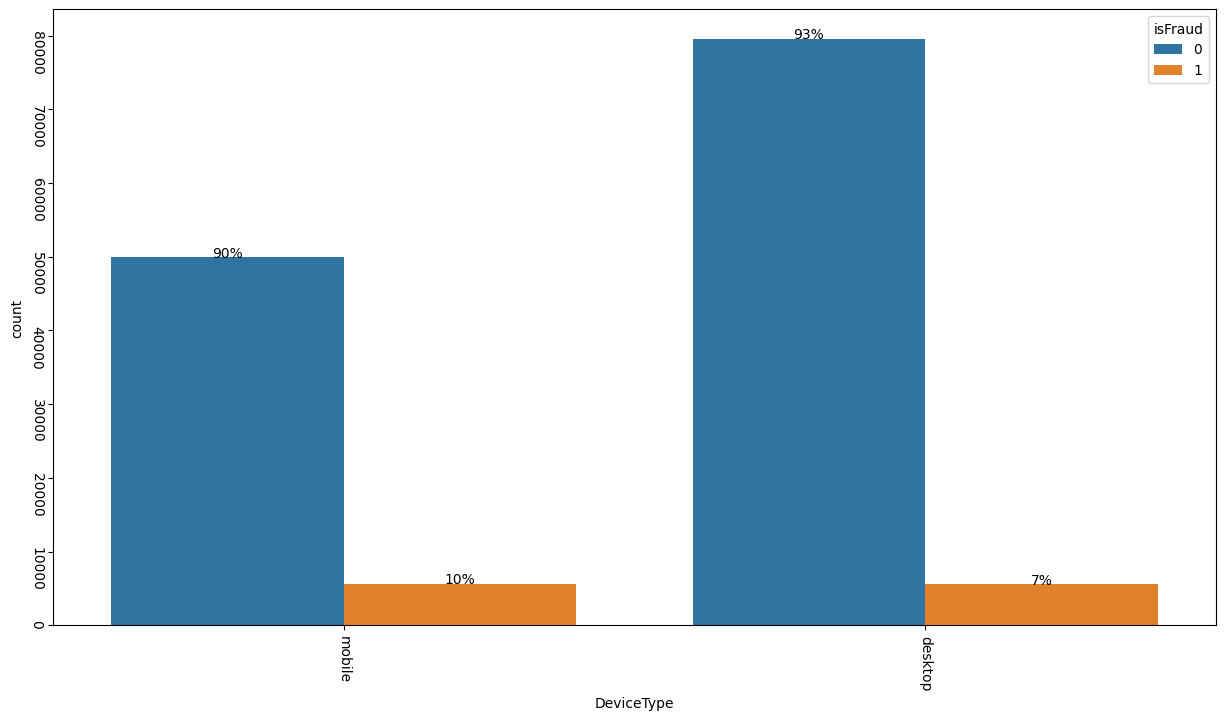

In [22]:
Plot_Cate_Correlation(train_set, col_A='DeviceType', col_B='isFraud',is_percentage=True)

### keypoint 1
DeviceType has only two values mobile and destop

isFraud proportion in the two DeviceType are similar<br>
so,we can see that user who use mobile and desktop are both to defraud

## DeviceInfo

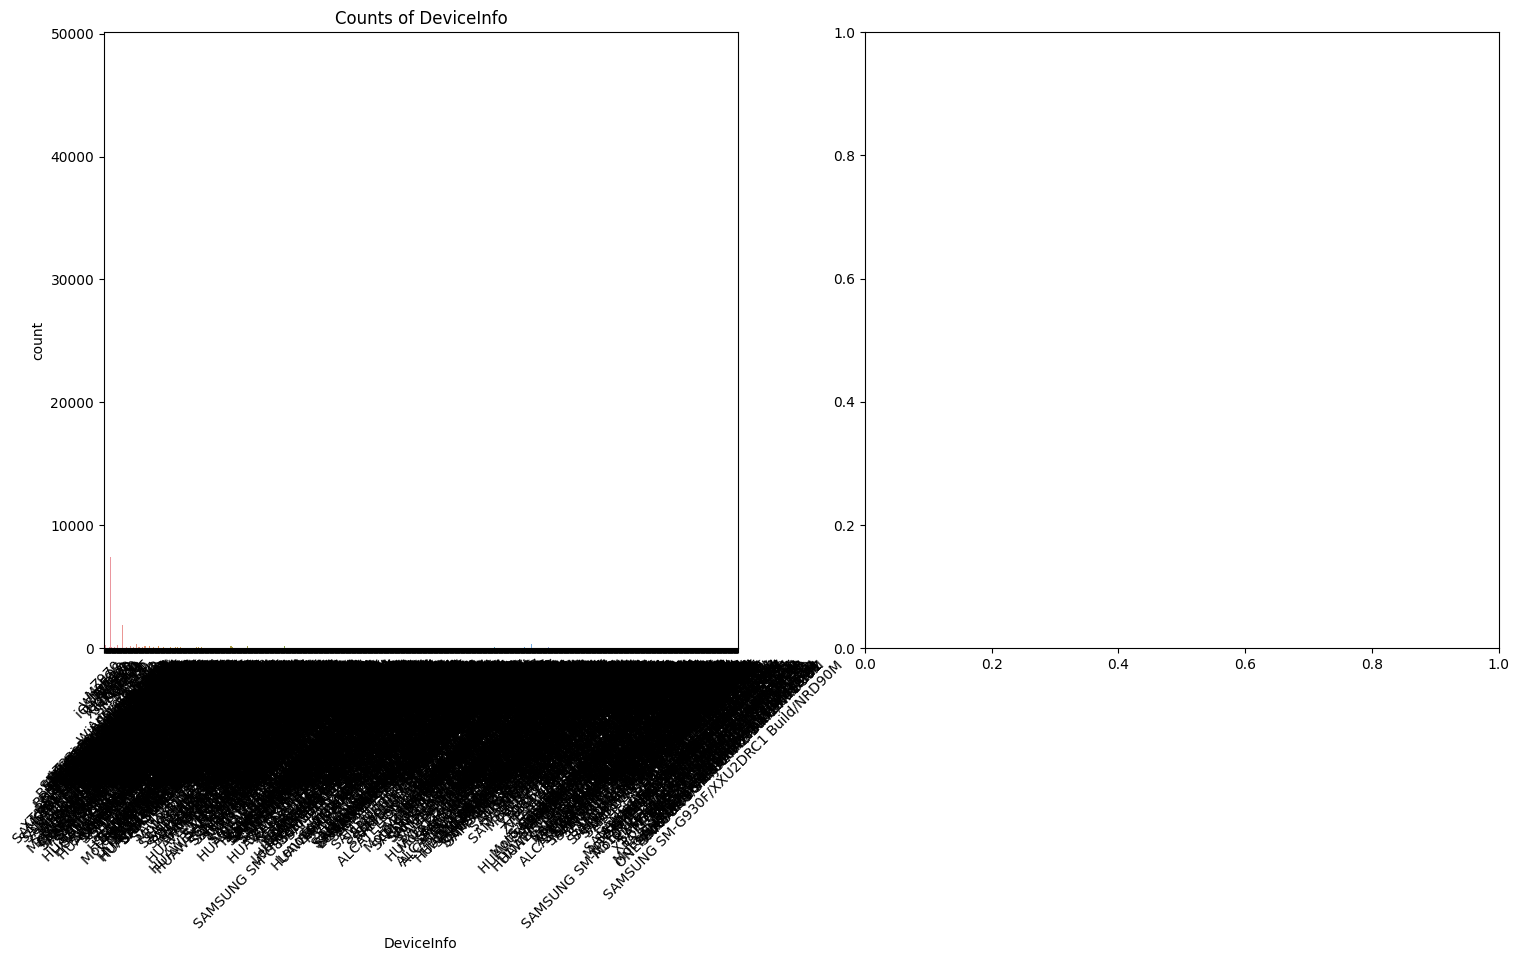

In [23]:
Plot_Cate_Feature(train_set, col='DeviceInfo')

In [24]:
train_set['DeviceInfo'].value_counts()

Windows                                        47722
iOS Device                                     19782
MacOS                                          12573
Trident/7.0                                     7440
rv:11.0                                         1901
rv:57.0                                          962
SM-J700M Build/MMB29K                            549
SM-G610M Build/MMB29K                            461
SM-G531H Build/LMY48B                            410
rv:59.0                                          362
SM-G935F Build/NRD90M                            334
SM-G955U Build/NRD90M                            328
SM-G532M Build/MMB29T                            316
ALE-L23 Build/HuaweiALE-L23                      312
SM-G950U Build/NRD90M                            290
SM-G930V Build/NRD90M                            274
rv:58.0                                          269
rv:52.0                                          256
SAMSUNG                                       


### keypoint 1
From the value counts of DeviceInfo, we can find that this feautre values are those definite information of device which users used

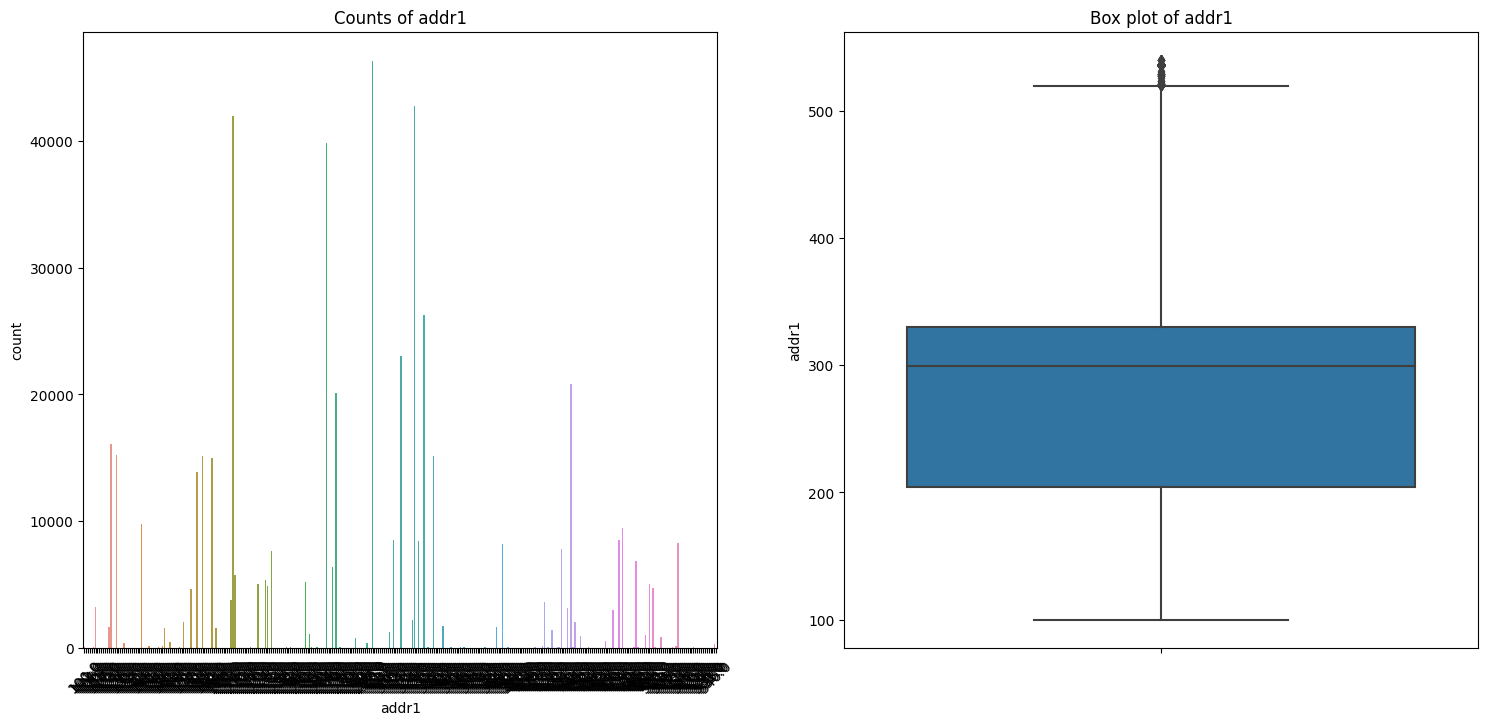

In [25]:
Plot_Cate_Feature(train_set, col='addr1')

## addr1

In [26]:
train_set['addr1'].value_counts()

299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
315.0    23078
441.0    20827
272.0    20141
123.0    16105
126.0    15243
184.0    15160
337.0    15149
191.0    14979
181.0    13856
143.0     9806
476.0     9478
310.0     8486
472.0     8478
327.0     8425
512.0     8268
387.0     8187
433.0     7831
231.0     7605
485.0     6816
269.0     6404
205.0     5725
225.0     5323
251.0     5216
494.0     5065
220.0     5041
226.0     4867
498.0     4744
177.0     4674
203.0     3808
420.0     3581
110.0     3220
436.0     3169
469.0     2940
324.0     2173
444.0     2033
170.0     2001
343.0     1734
384.0     1670
122.0     1617
194.0     1572
158.0     1562
428.0     1425
308.0     1279
253.0     1058
492.0      987
448.0      923
502.0      835
284.0      773
465.0      503
161.0      421
296.0      367
130.0      342
536.0      309
157.0      169
511.0      157
418.0      101
148.0       96
356.0       90
348.0       85
242.0       84
508.0       70
254.0     


Accourding to the value counts of addr1, two points are clear. <br>
- these addresses are encoded to number
- this feature is a higih cardinal variable including many rare value



## addr2

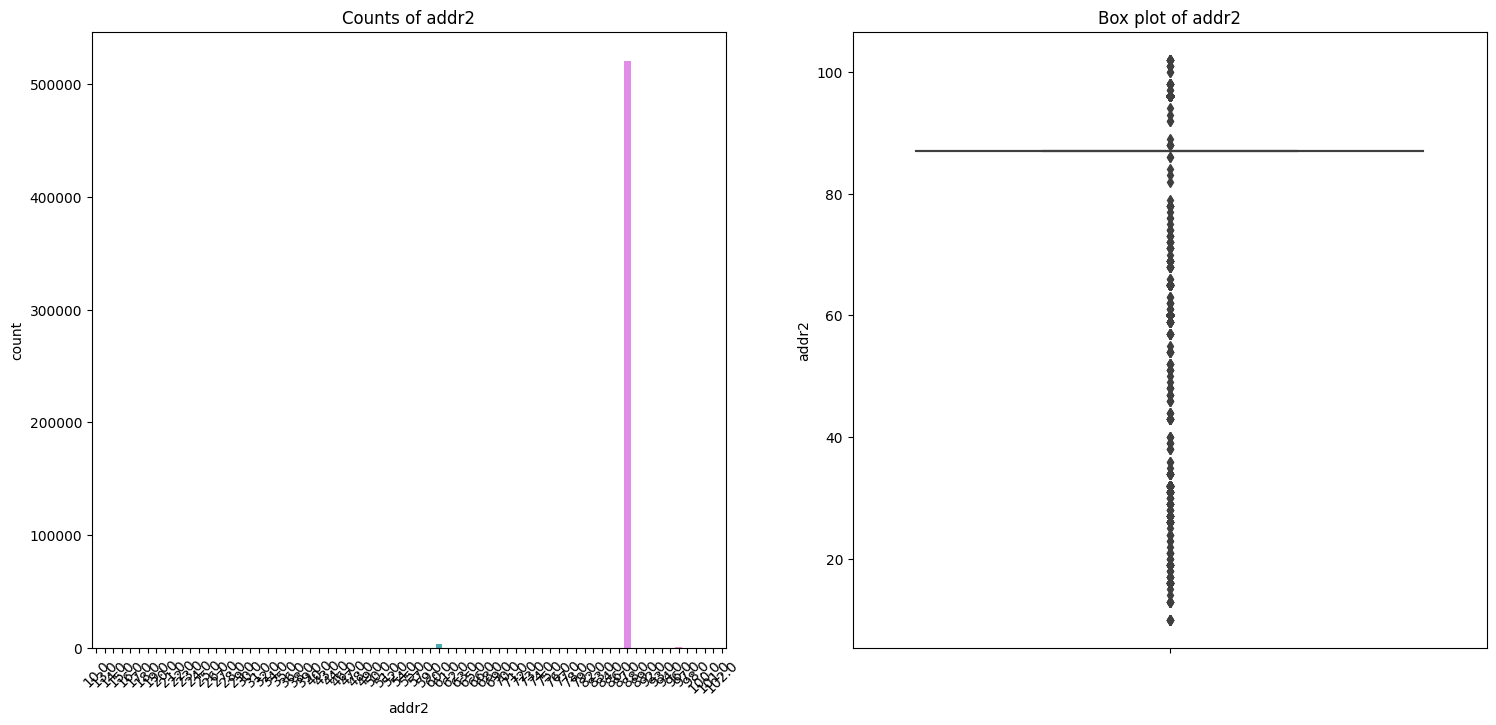

In [28]:
Plot_Cate_Feature(train_set,col = 'addr2')

In [29]:
train_set['addr2'].value_counts()

87.0     520481
60.0       3084
96.0        638
32.0         91
65.0         82
16.0         55
31.0         47
19.0         33
26.0         25
27.0         20
69.0         17
59.0         17
34.0         16
43.0         12
102.0        11
29.0         11
98.0         11
68.0         10
57.0         10
78.0          8
10.0          8
71.0          7
17.0          7
13.0          7
72.0          6
54.0          6
88.0          5
52.0          5
73.0          5
21.0          5
48.0          4
62.0          4
30.0          4
51.0          4
47.0          4
101.0         4
28.0          4
46.0          3
24.0          3
39.0          3
38.0          3
74.0          3
18.0          3
40.0          3
20.0          3
61.0          3
44.0          3
23.0          2
86.0          2
76.0          2
97.0          2
63.0          2
100.0         2
66.0          2
36.0          2
92.0          2
82.0          1
94.0          1
55.0          1
89.0          1
15.0          1
84.0          1
79.0    

addr2 has a very common value:87, and the other values are extremely less.<br>
- so,we should guess what addr2 means
- other values can be regarded as one same class in encoding step

## card1—card6

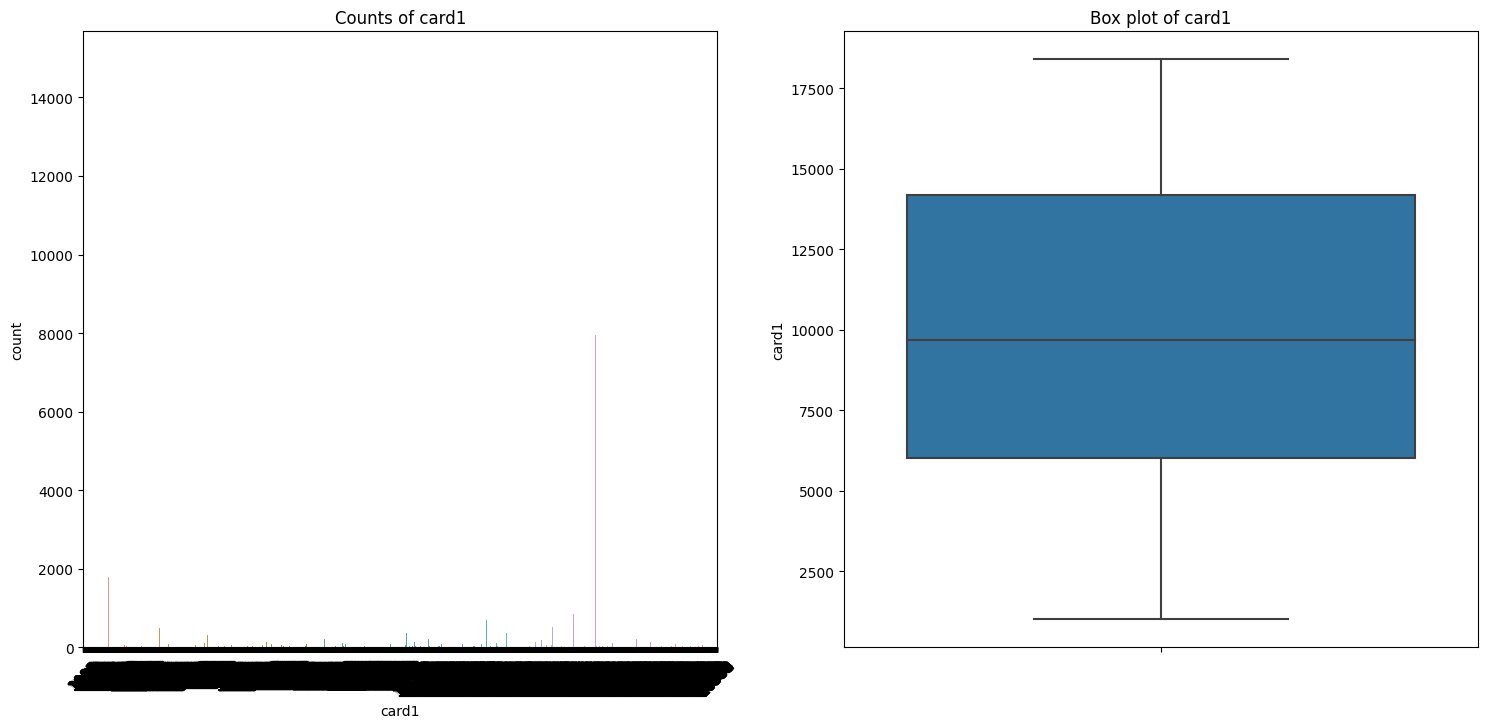

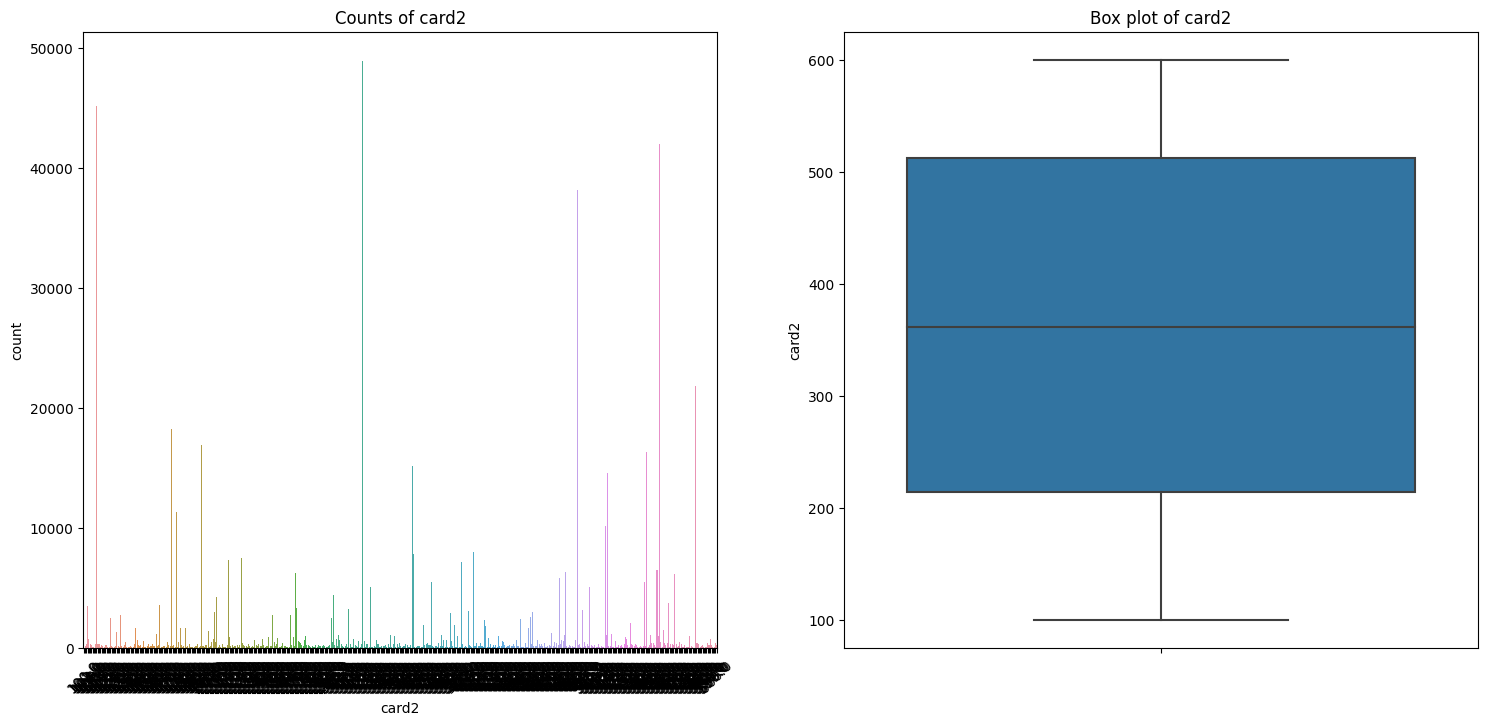

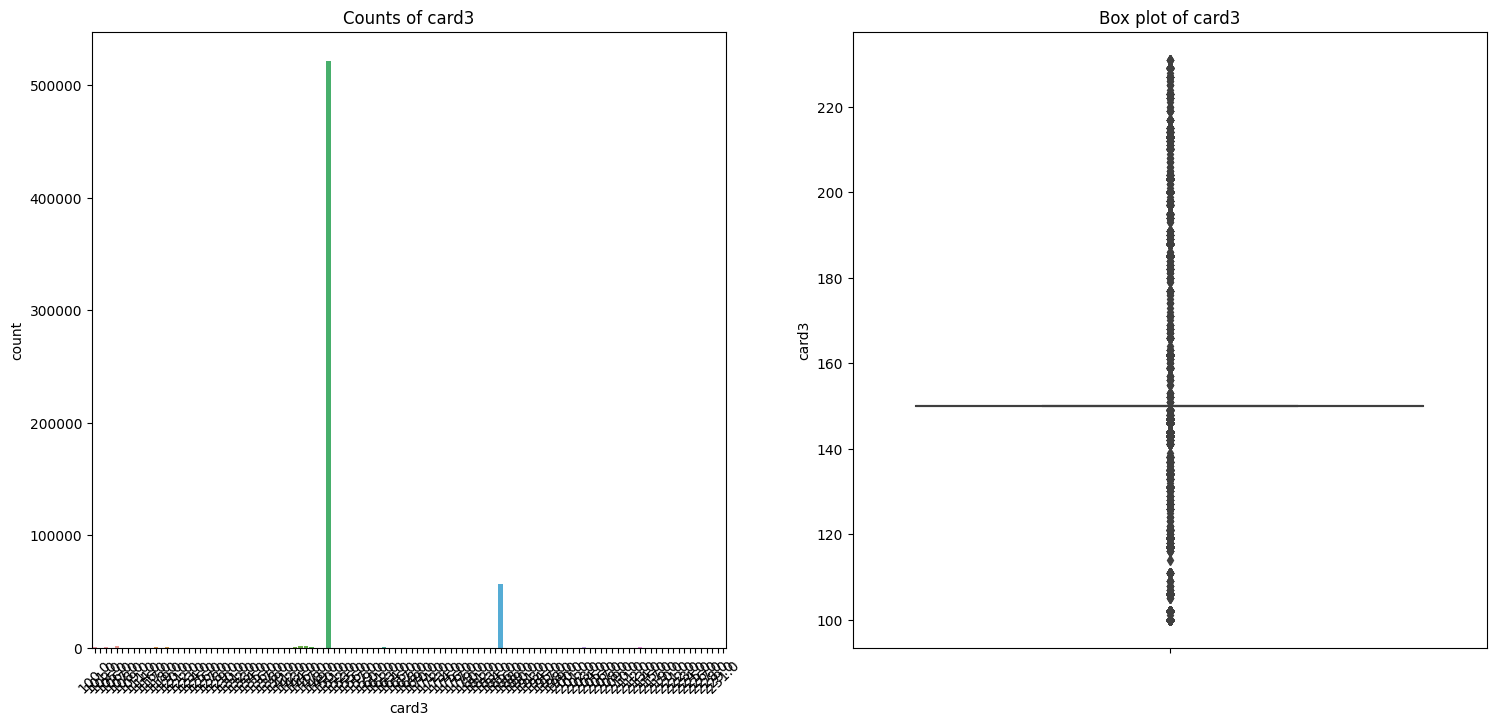

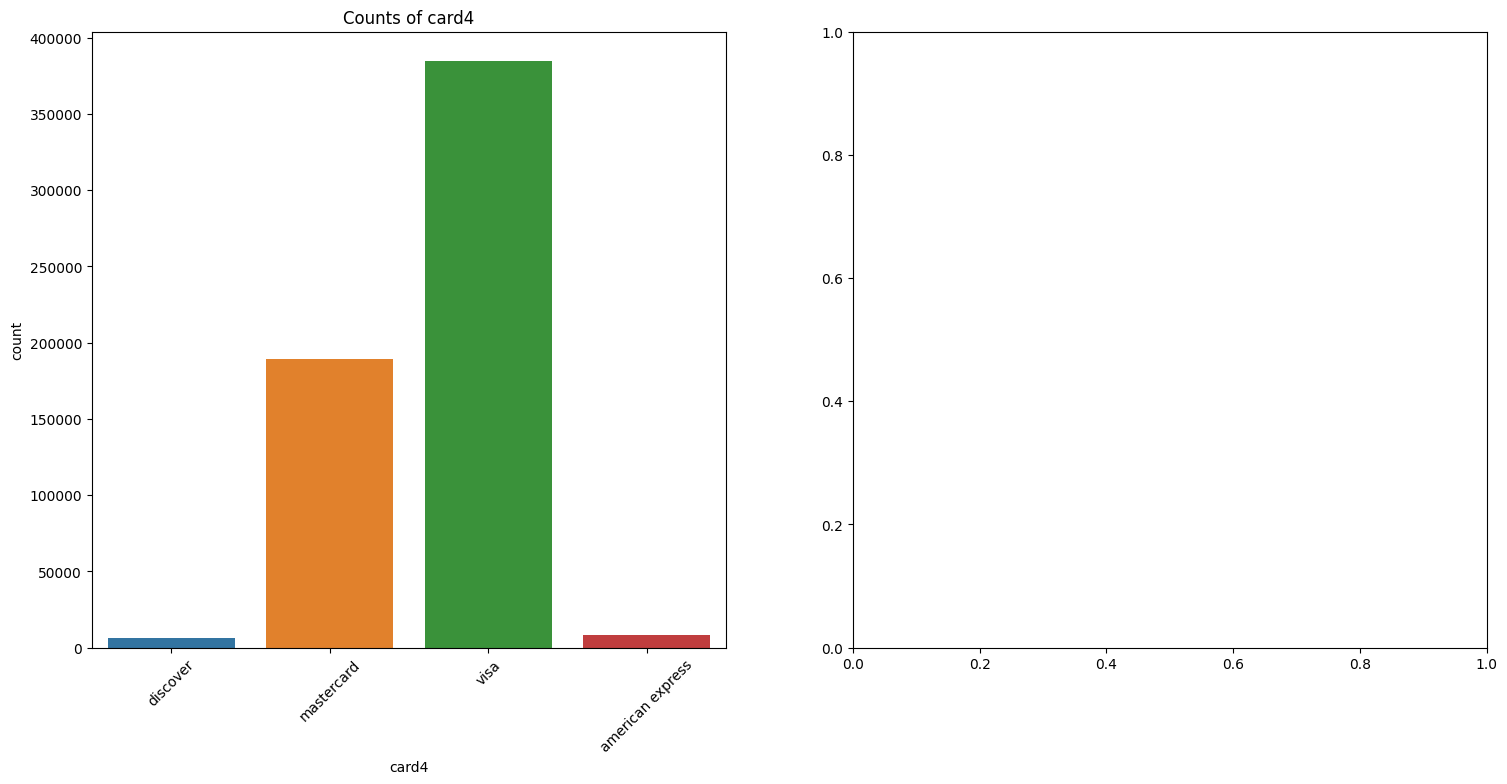

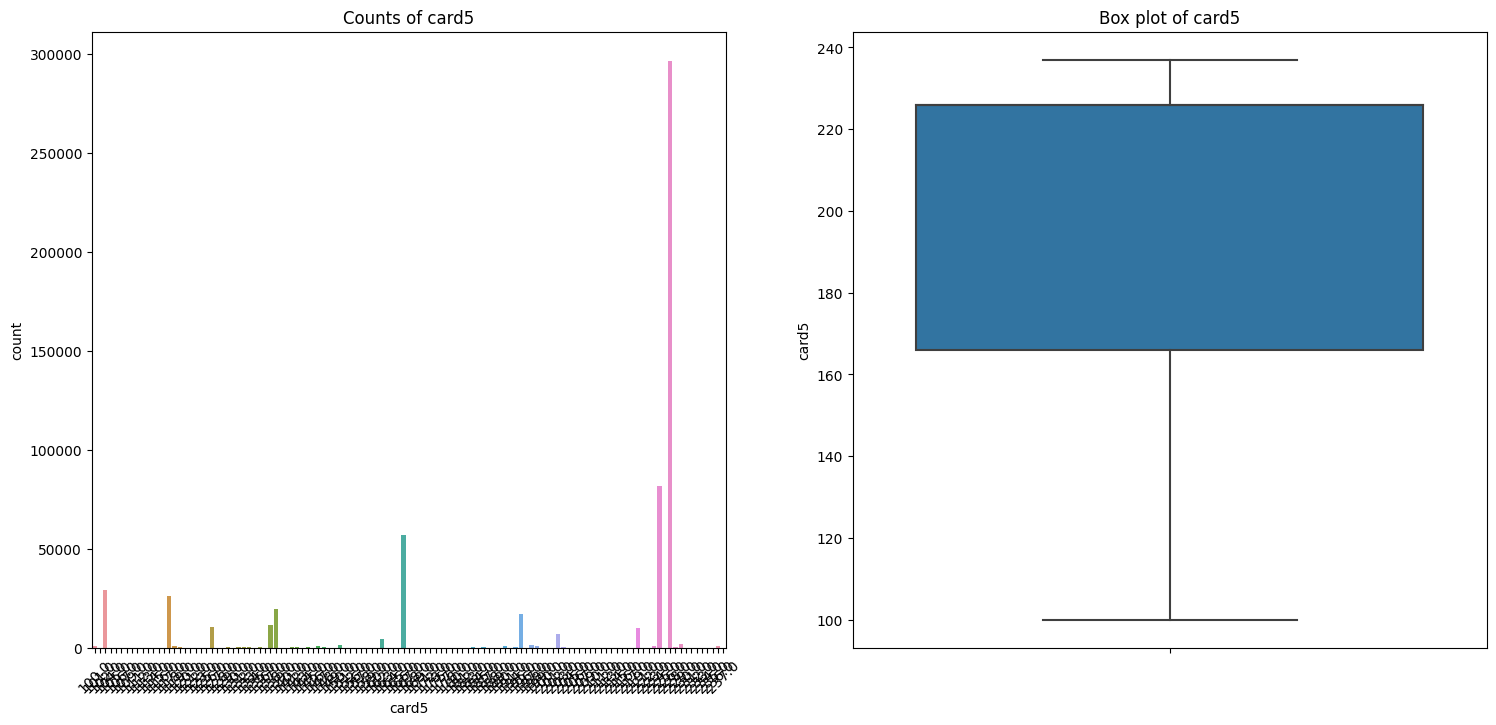

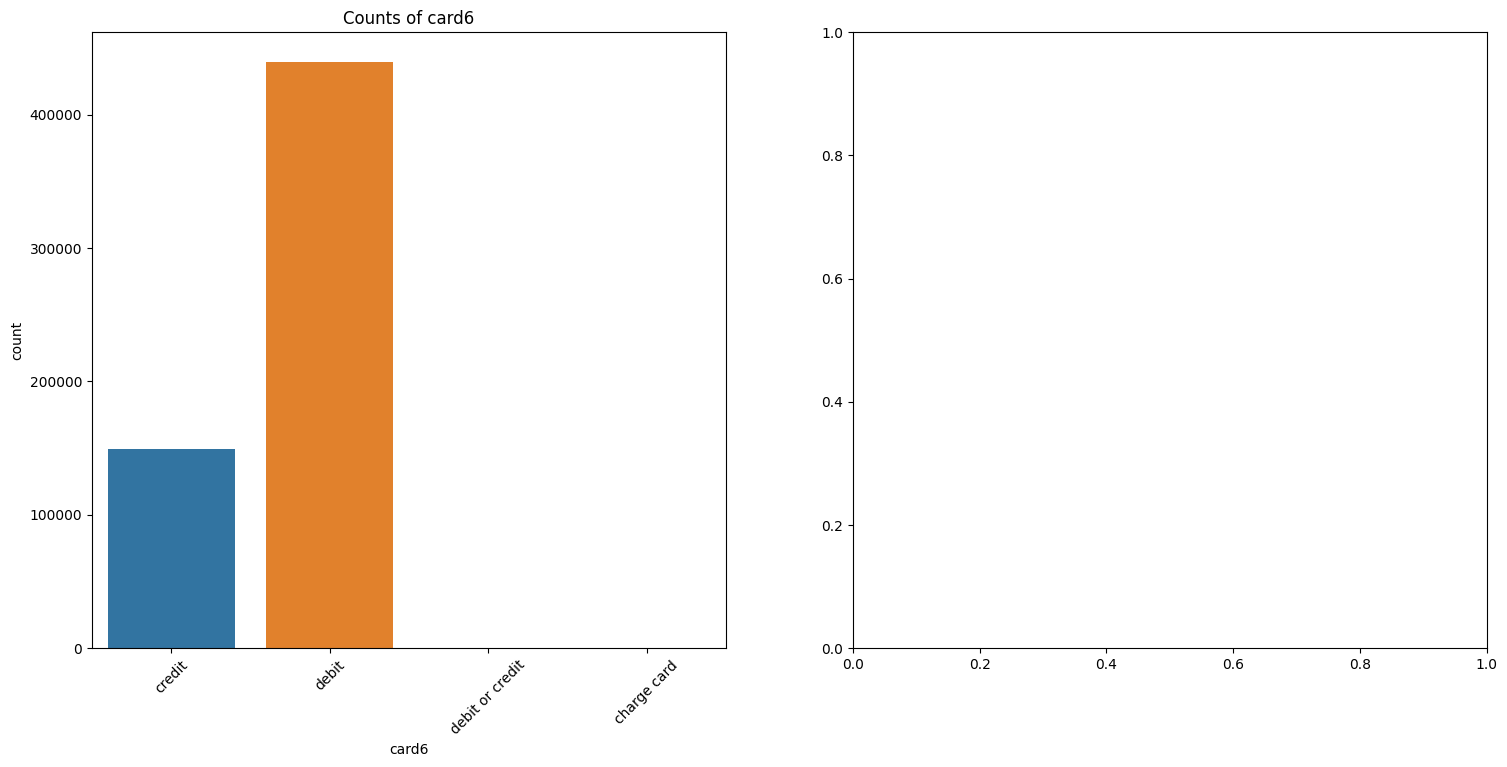

In [31]:
for idx in range(1,7):
    Plot_Cate_Feature(train_set, col='card' + str(idx))


- by draw pictures, we can find that card1 and card2 are both high cardinal feature
- card3-card6 are more like categorical features, bacause they have limited values

so,we need to use categorical API to show the correlation in card3-card6 with 'isFraud'

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

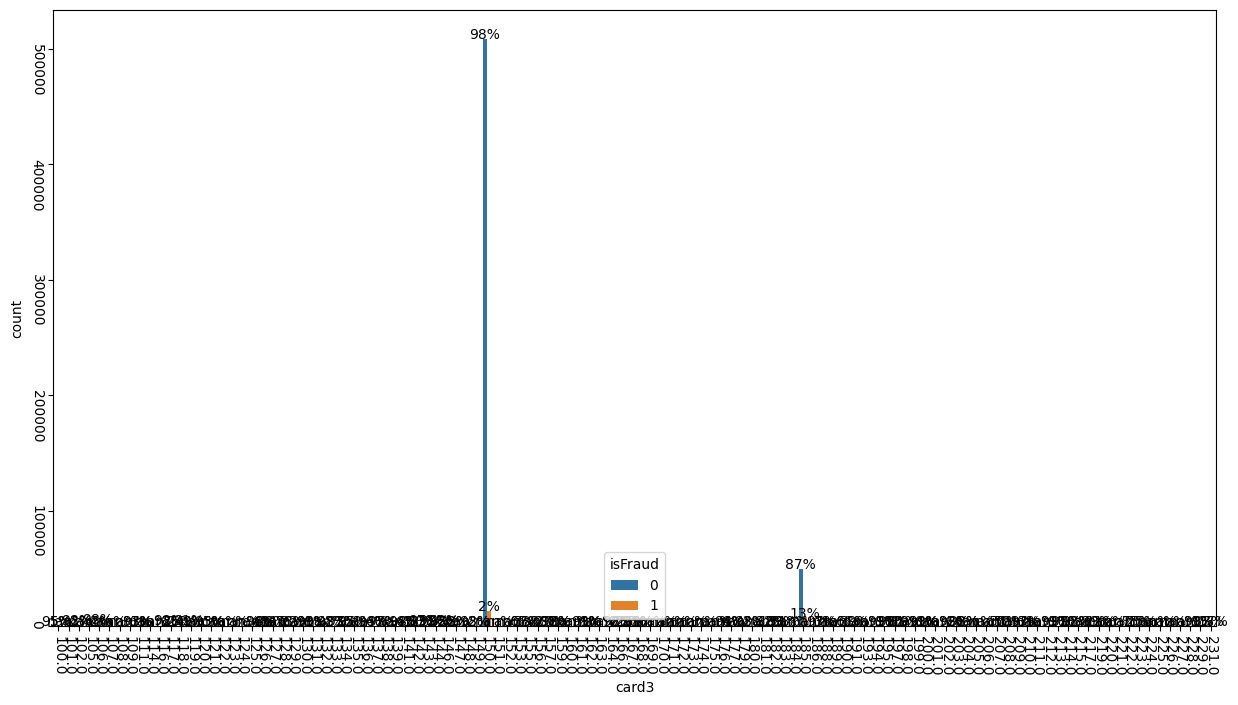

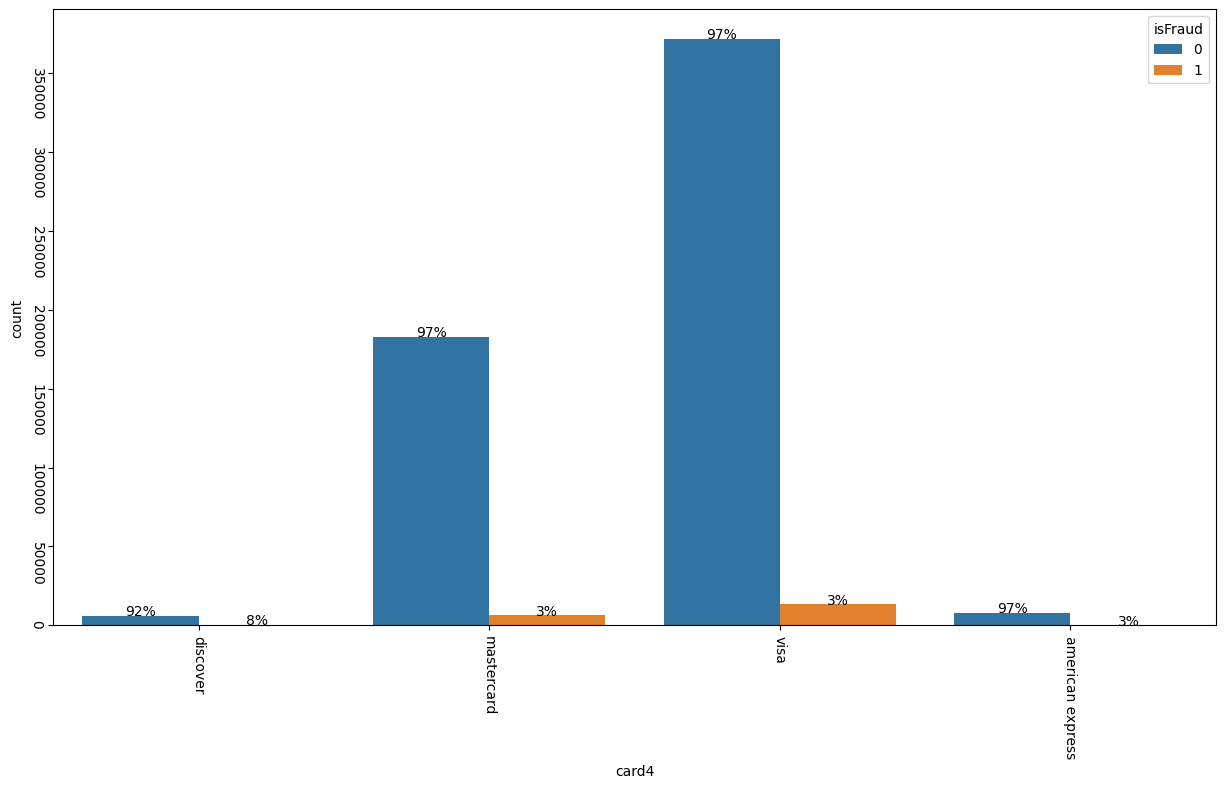

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

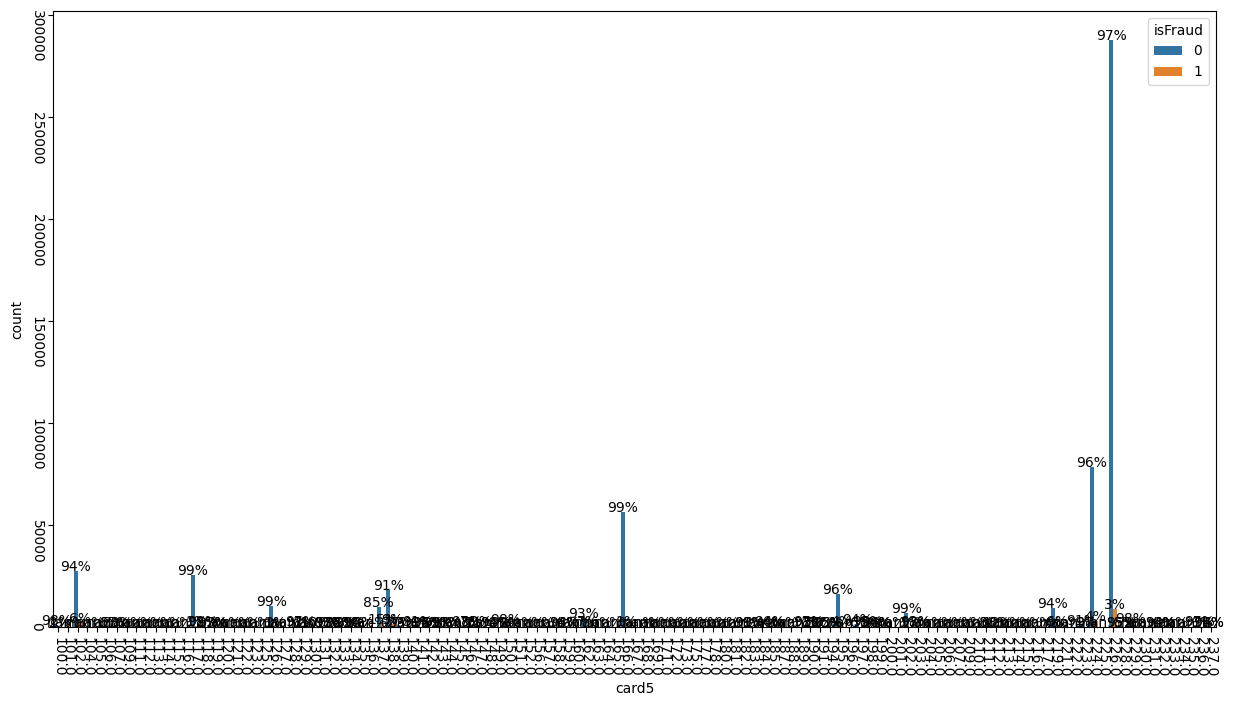

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


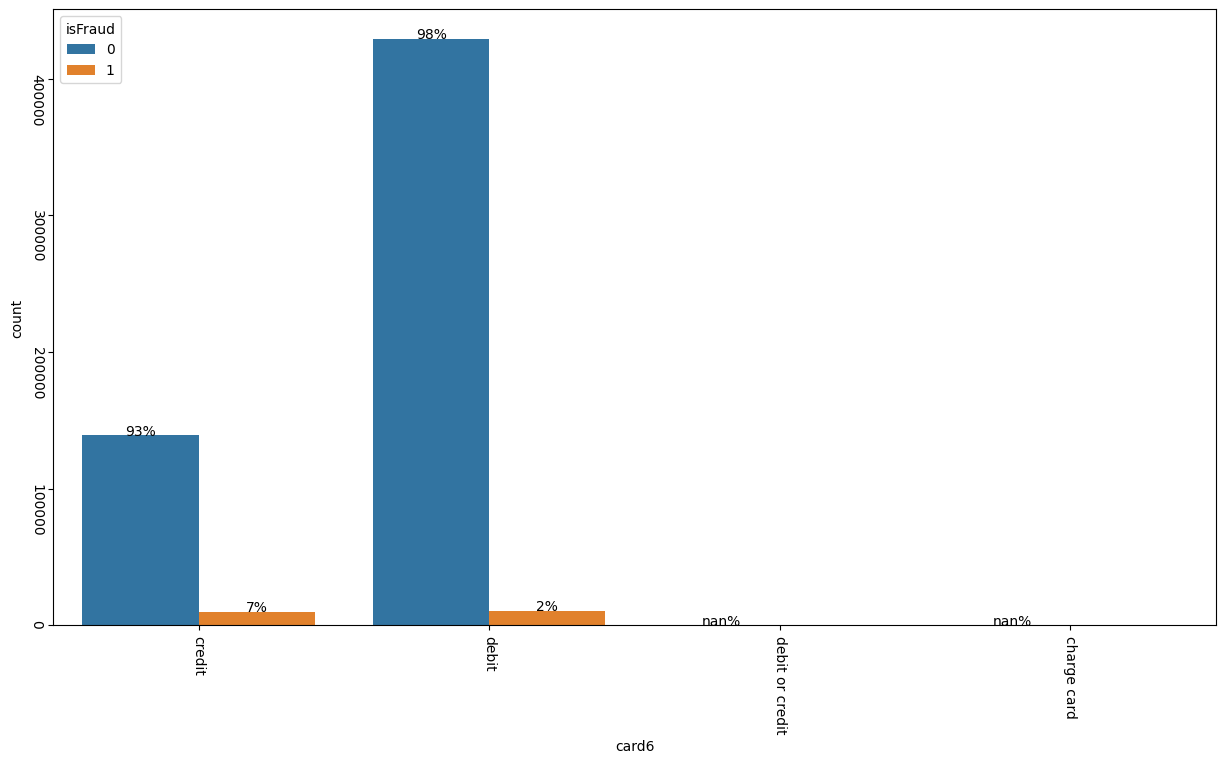

In [33]:
for idx in range(3, 7):
    Plot_Cate_Correlation(train_set, col_A = 'card'+str(idx), col_B='isFraud',is_percentage=True)

Not too much to find through pictures above

## M1—M9

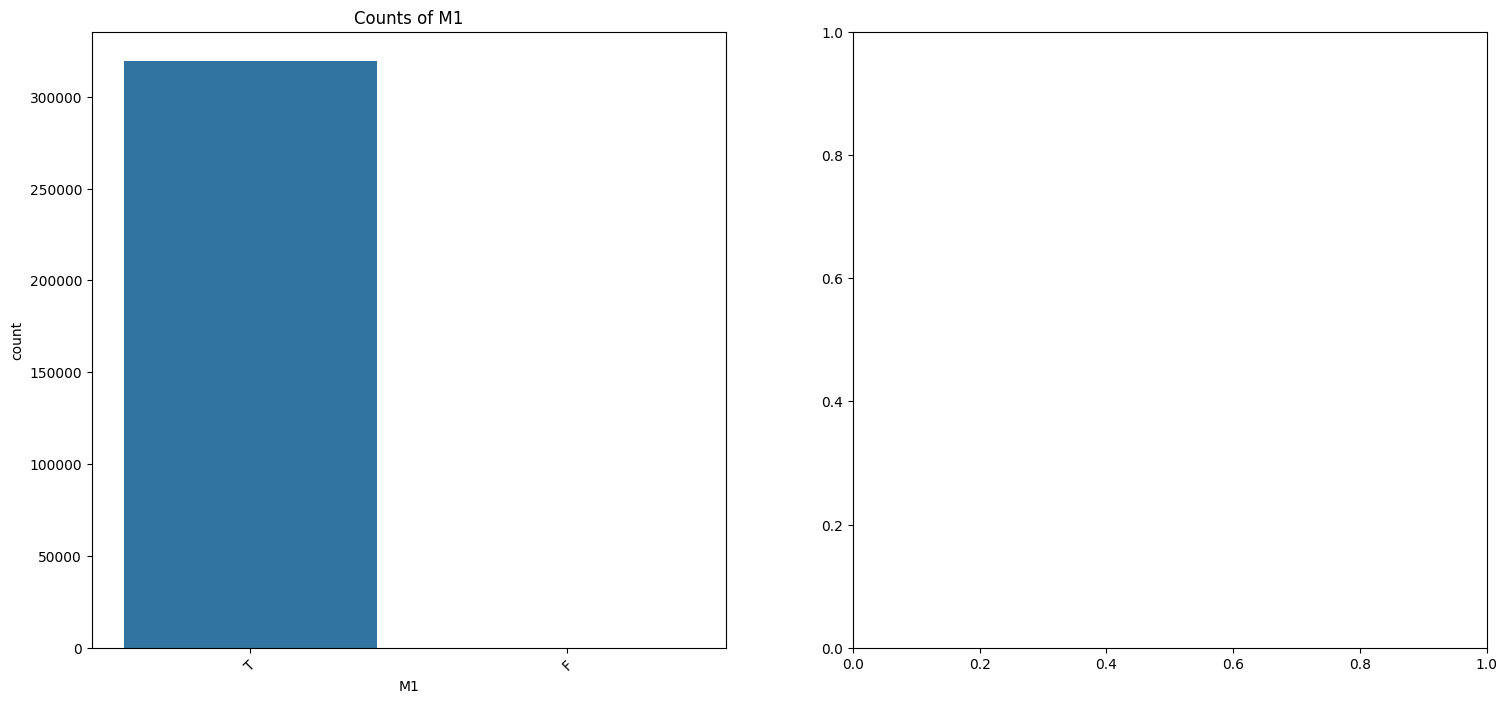

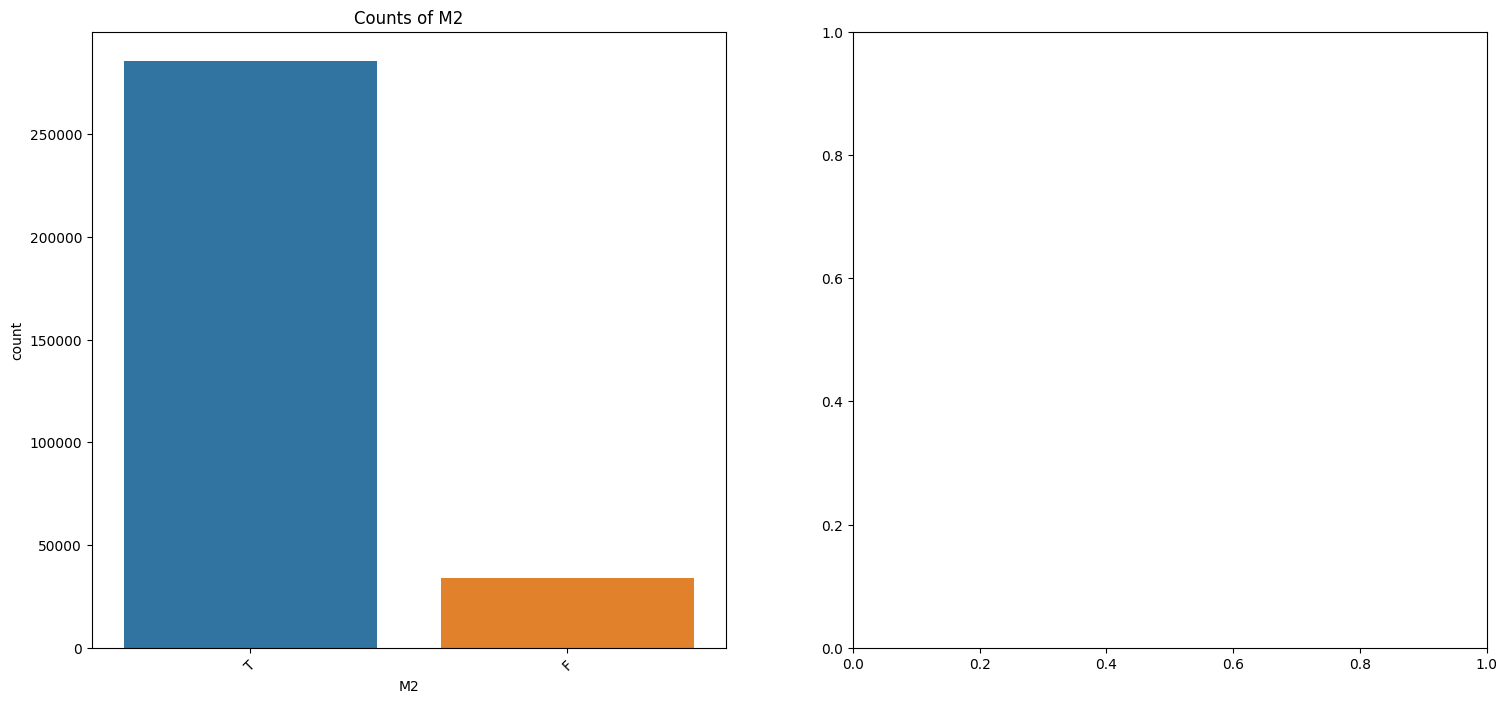

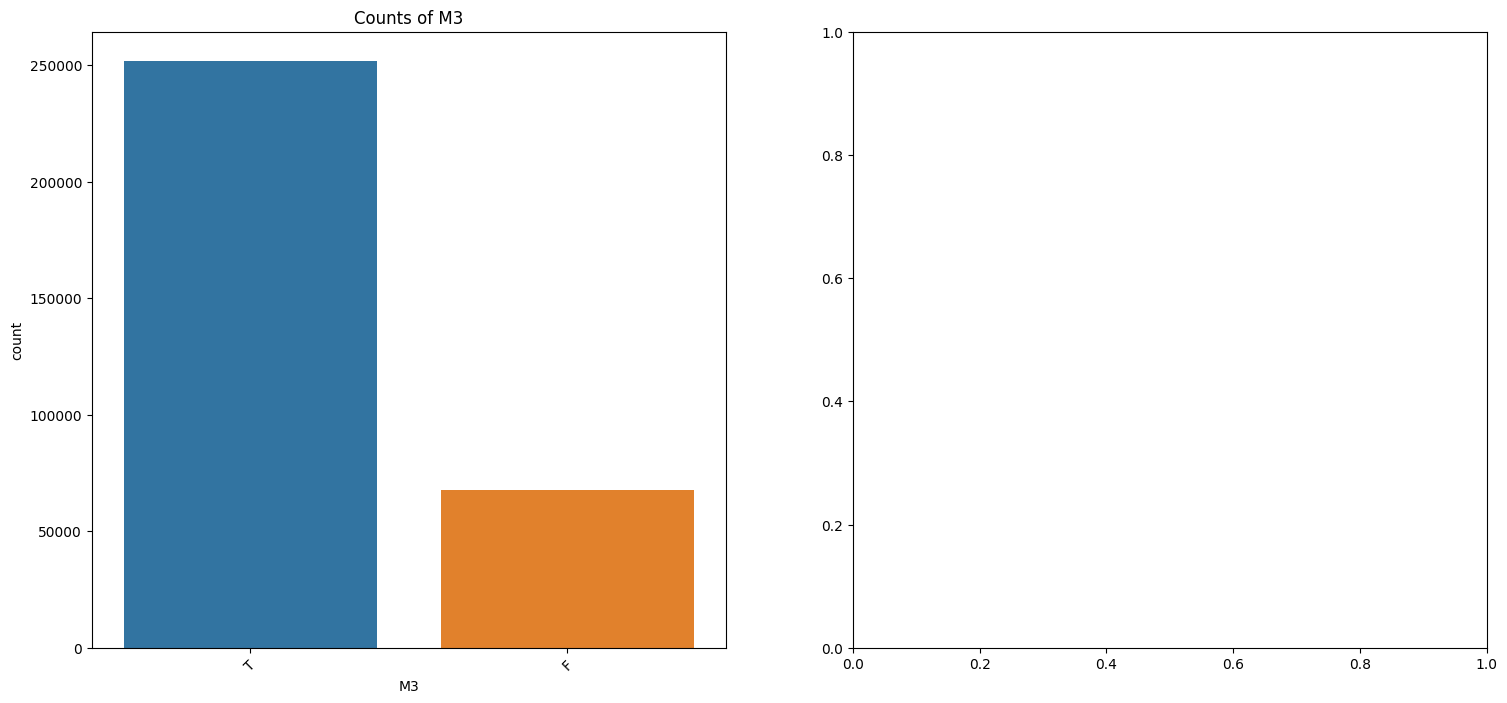

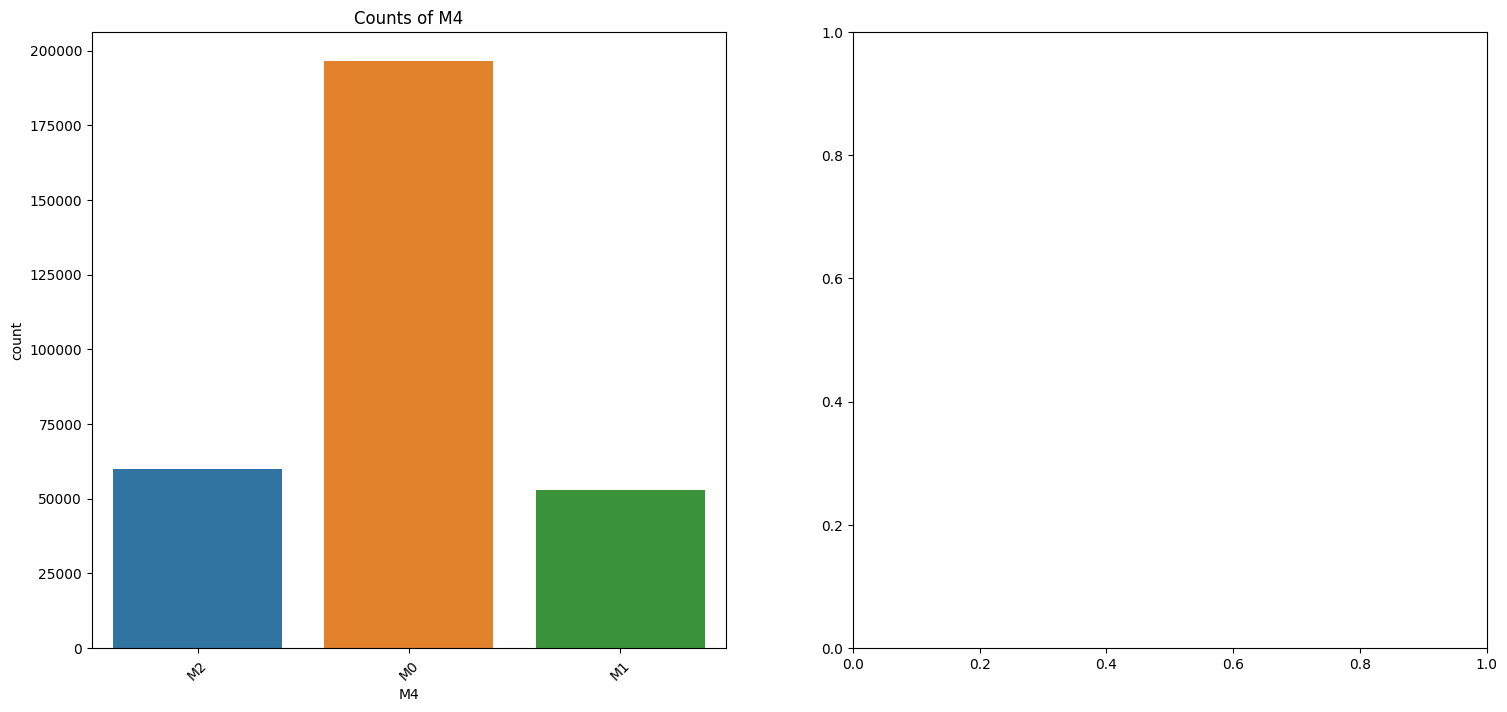

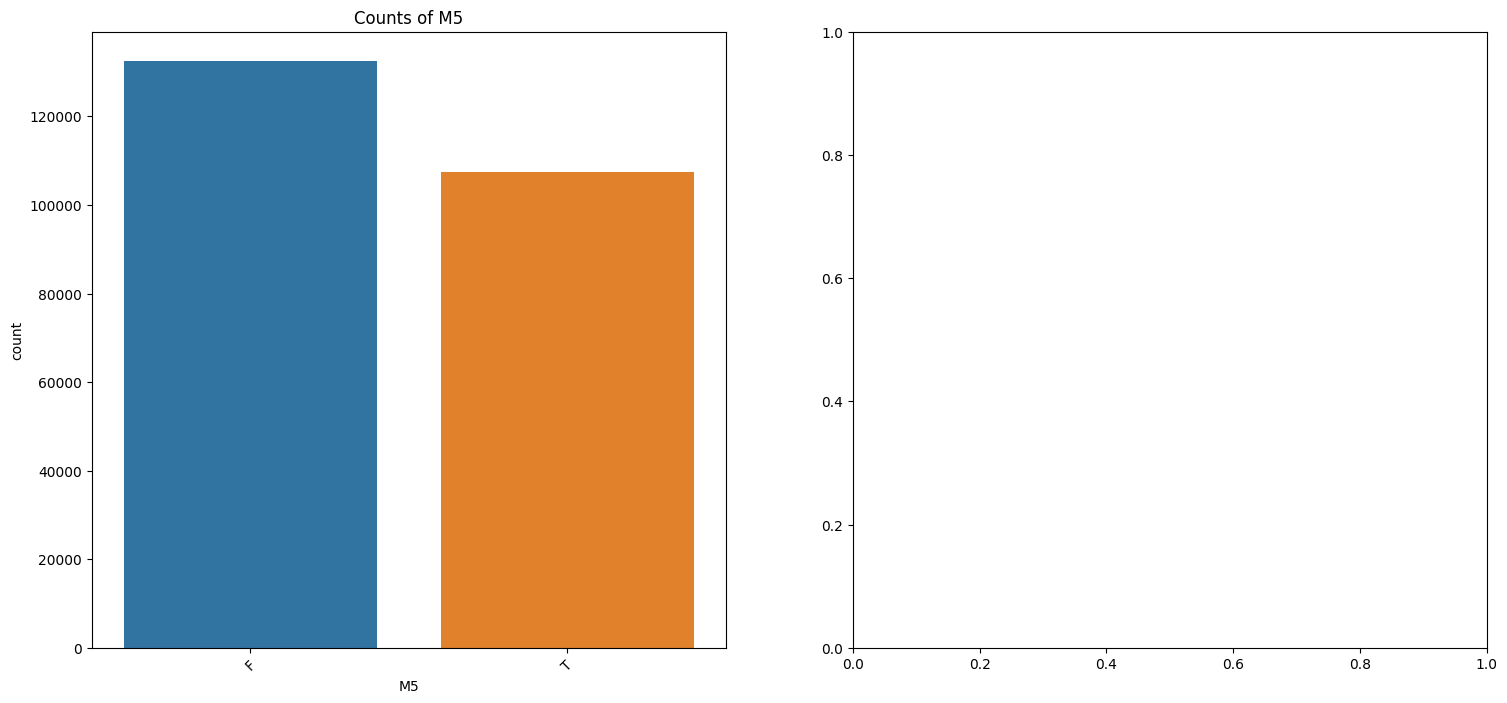

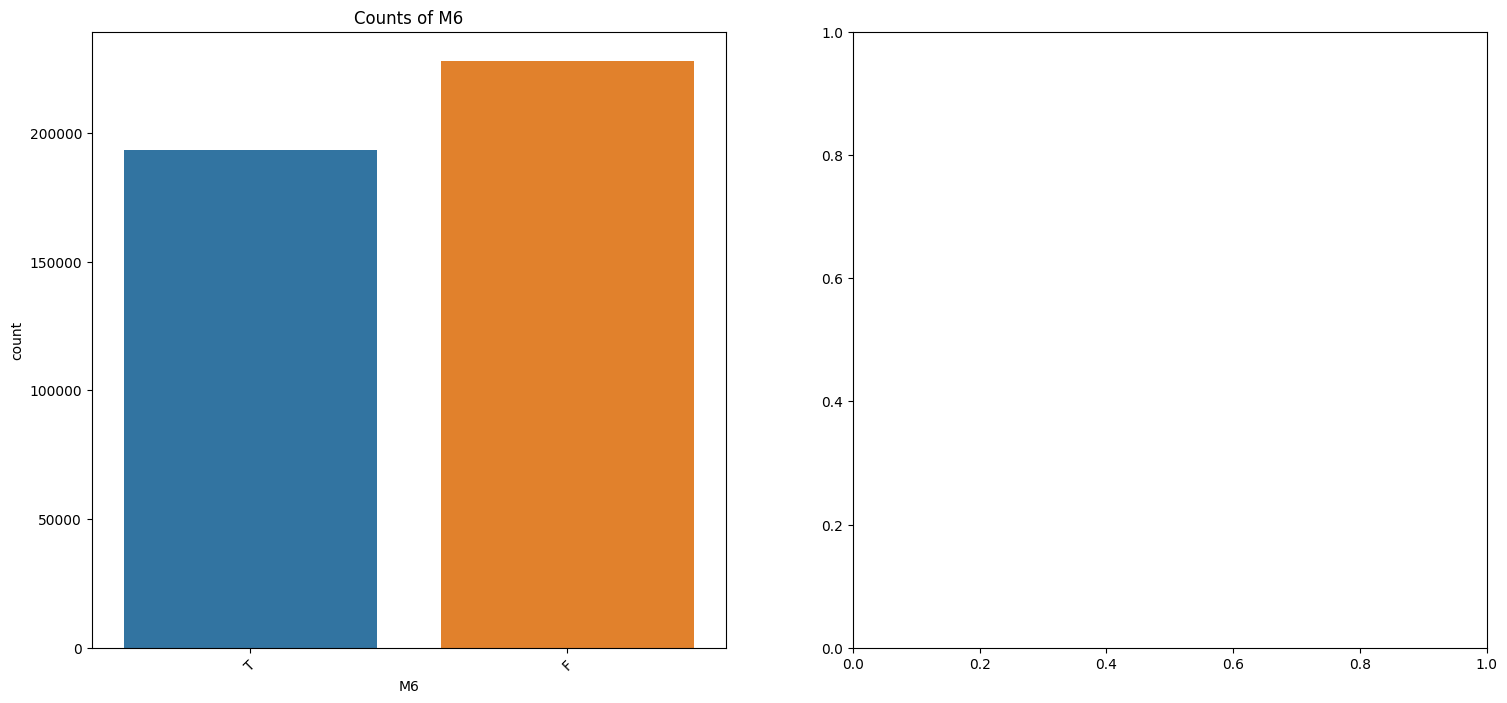

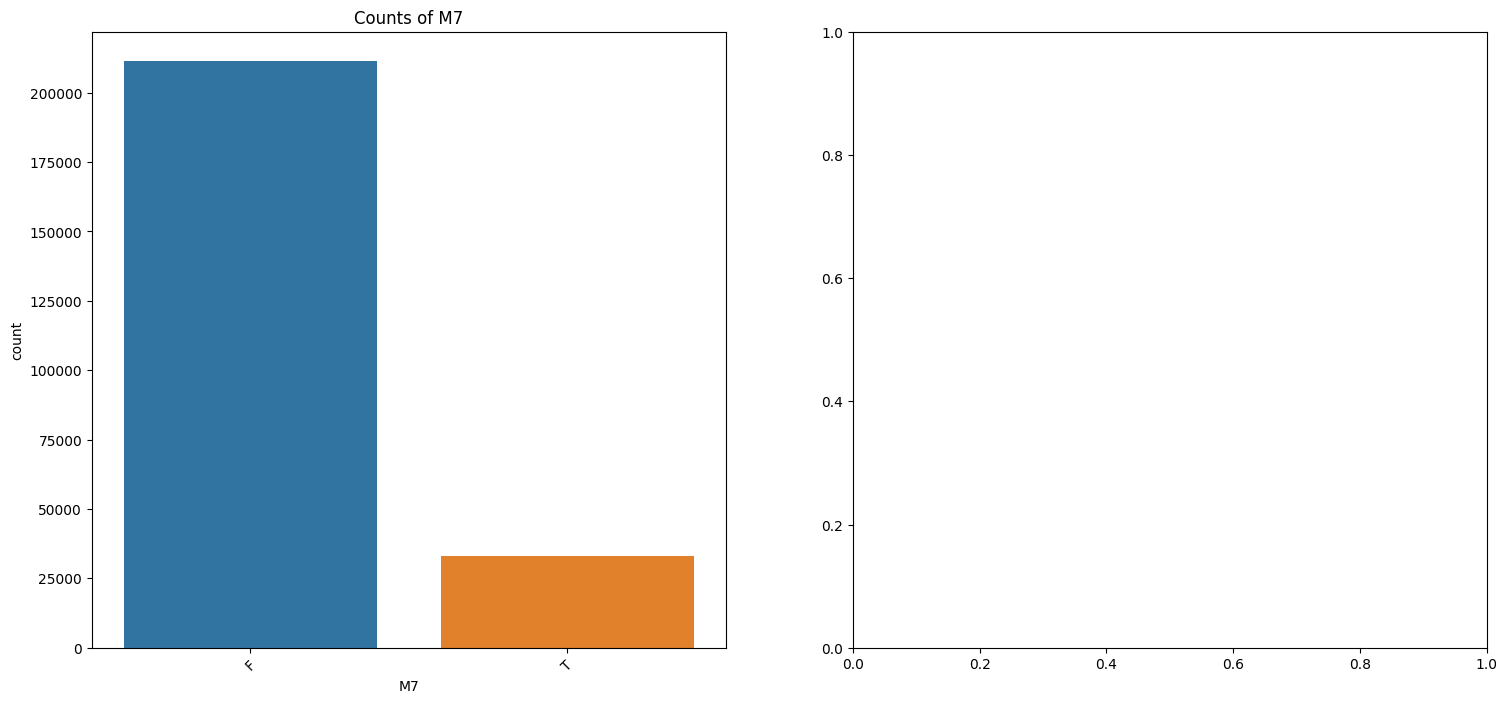

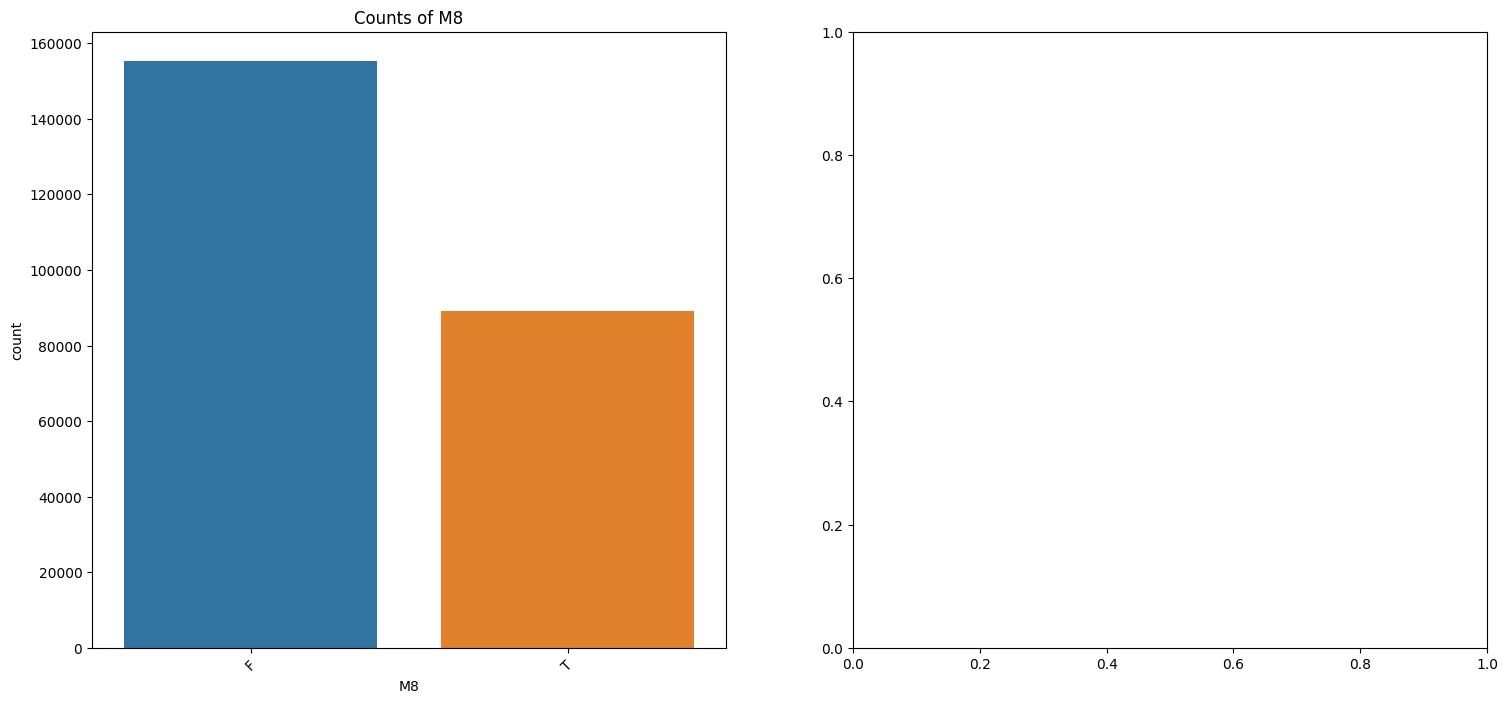

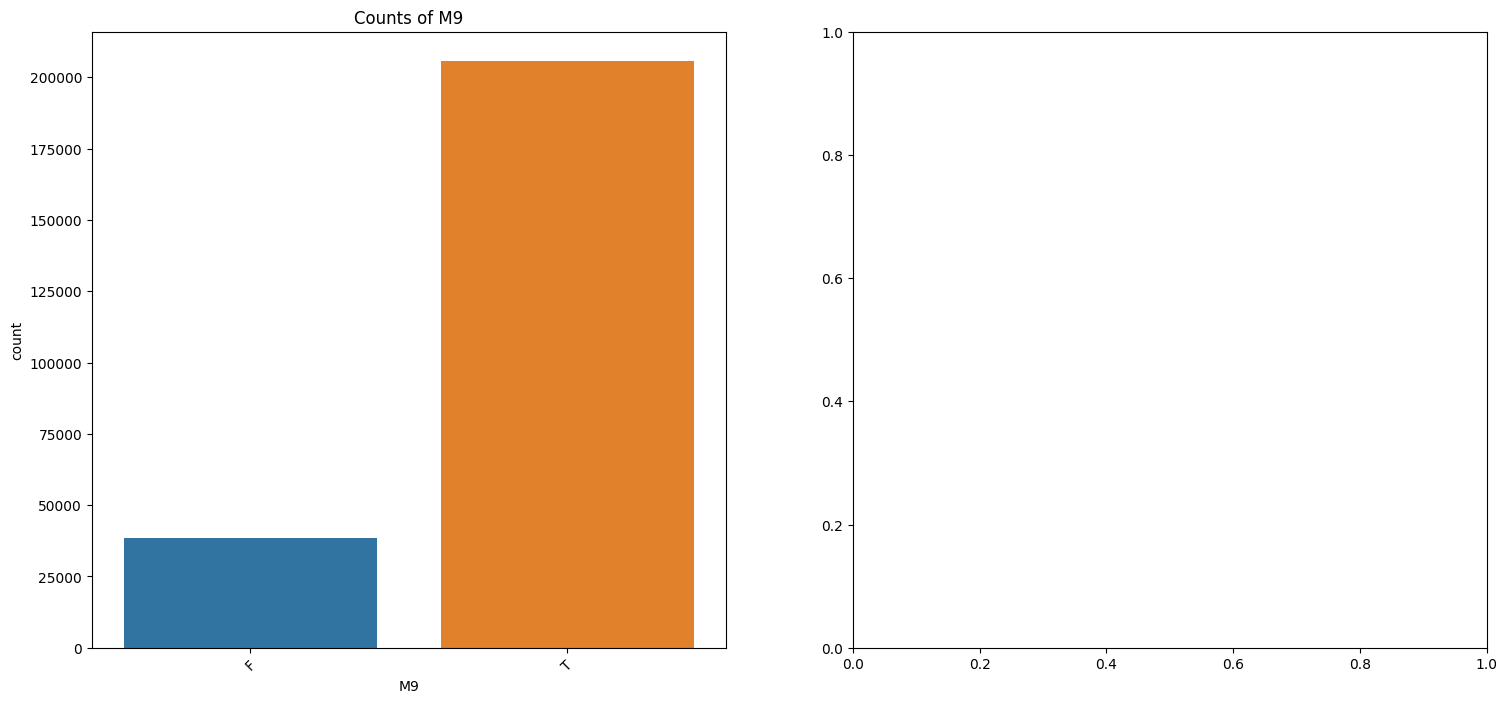

In [40]:
for idx in range(1,10):
    Plot_Cate_Feature(train_set, col ='M' +str(idx))

posx and posy should be finite values
posx and posy should be finite values


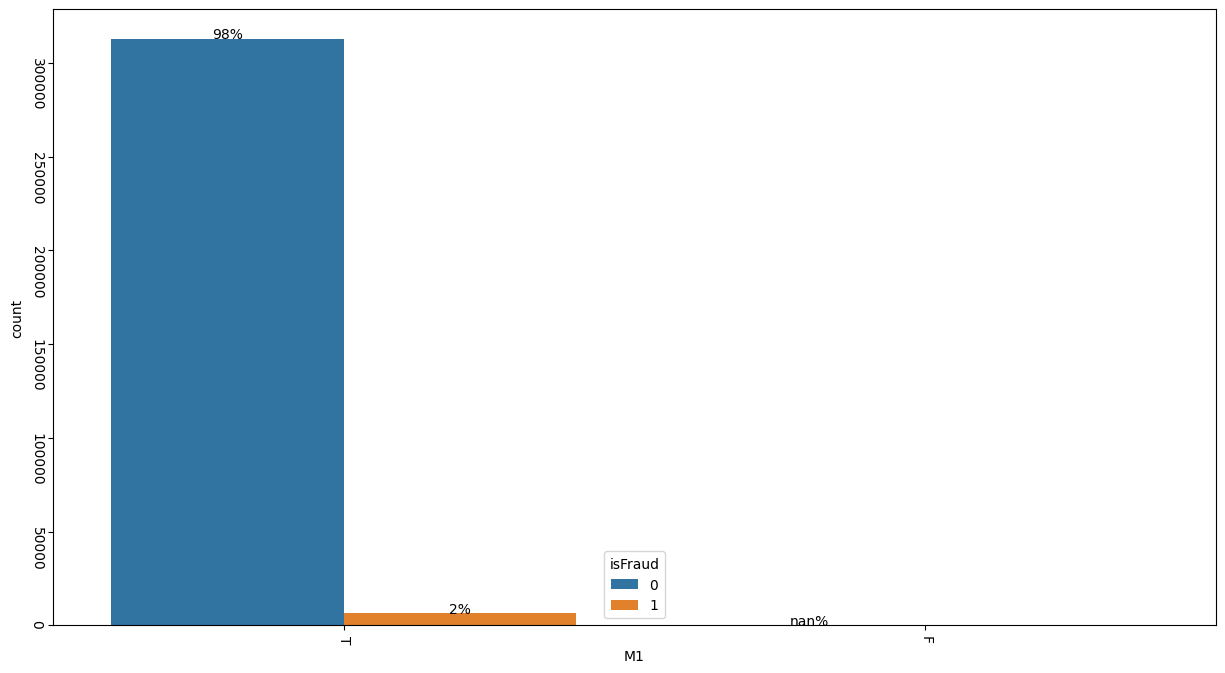

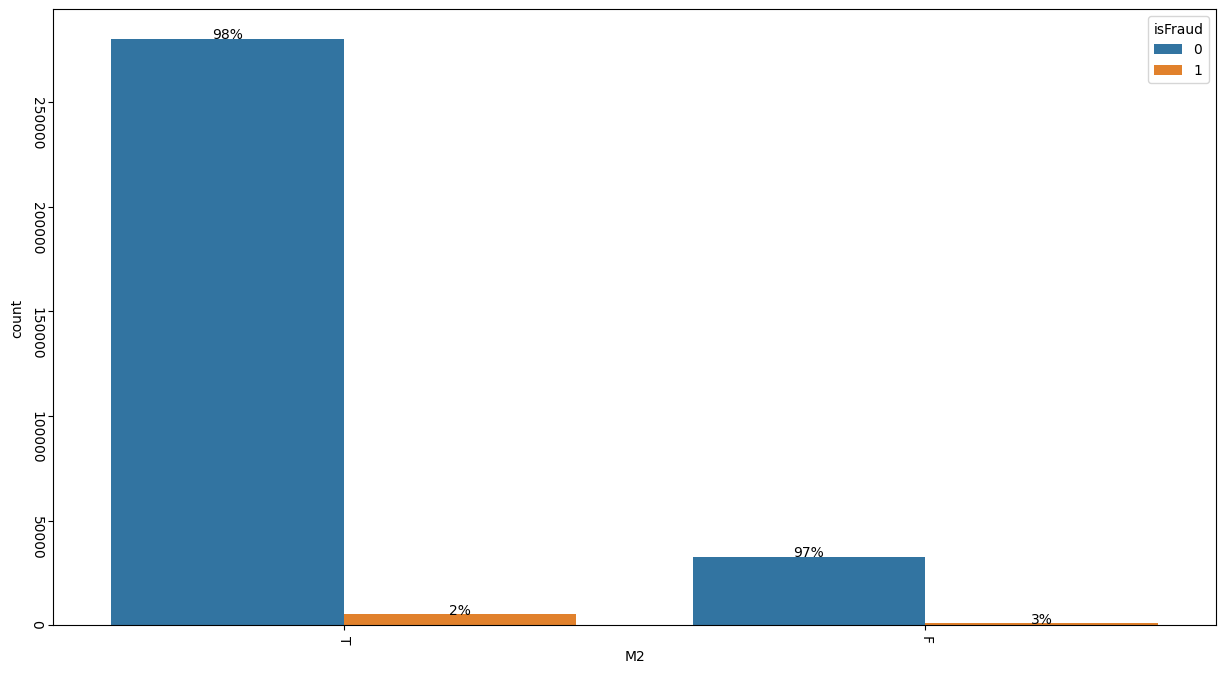

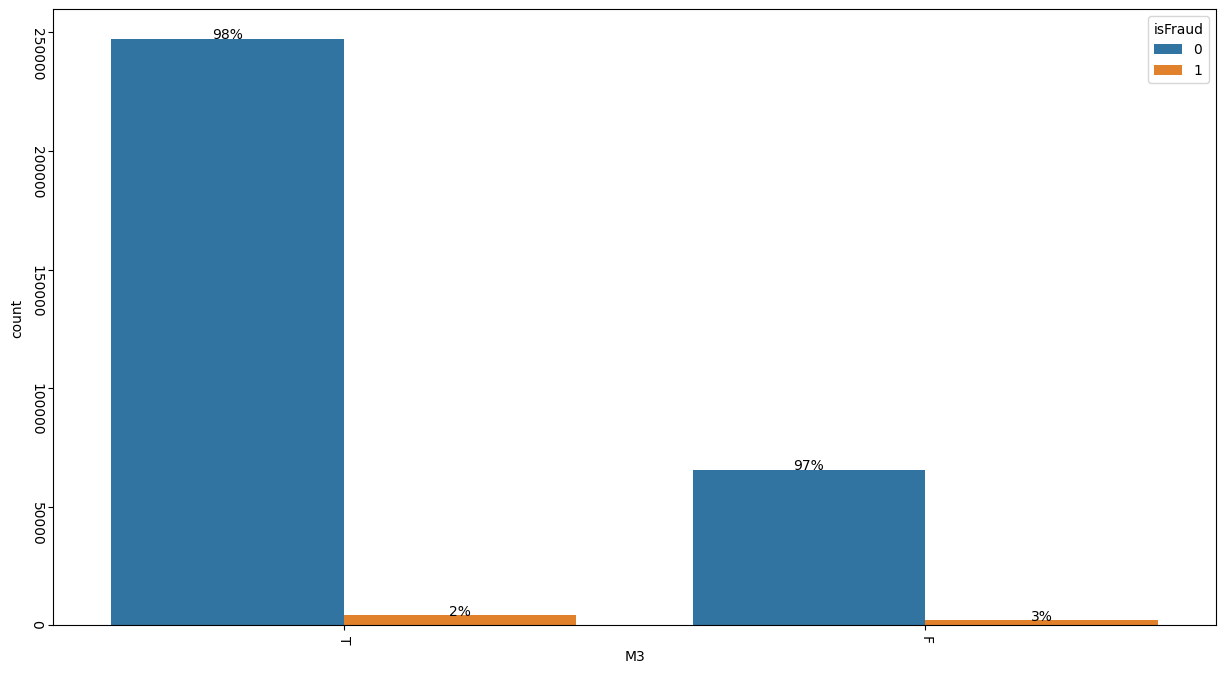

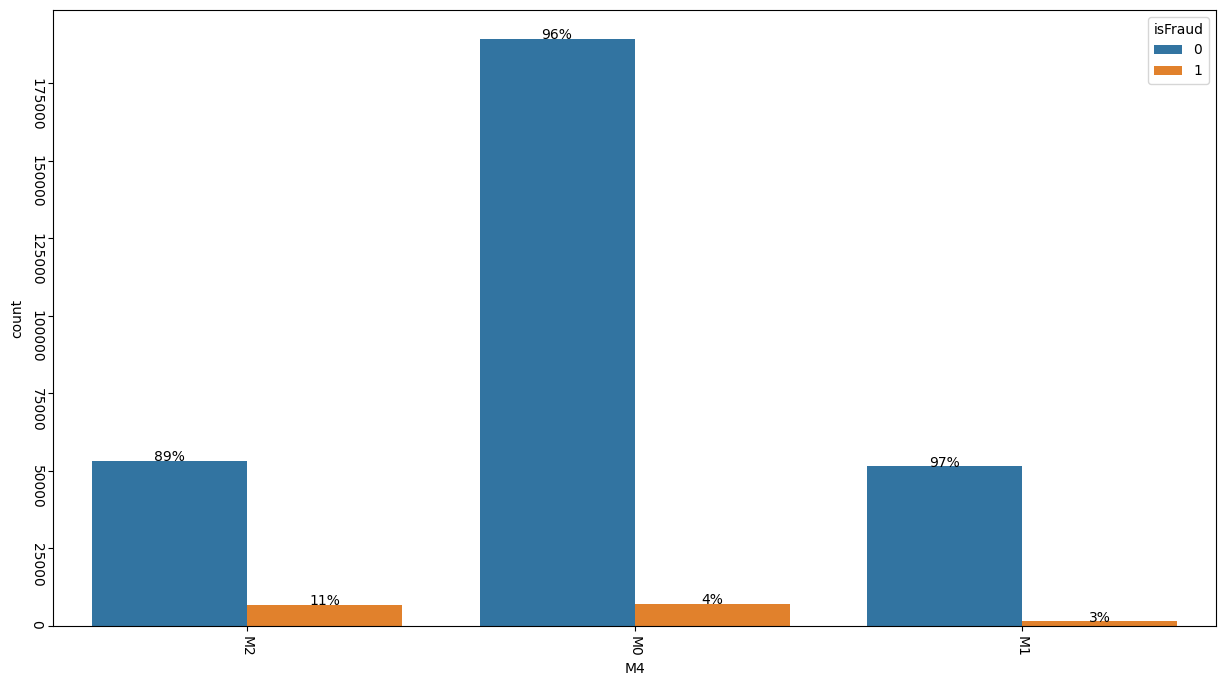

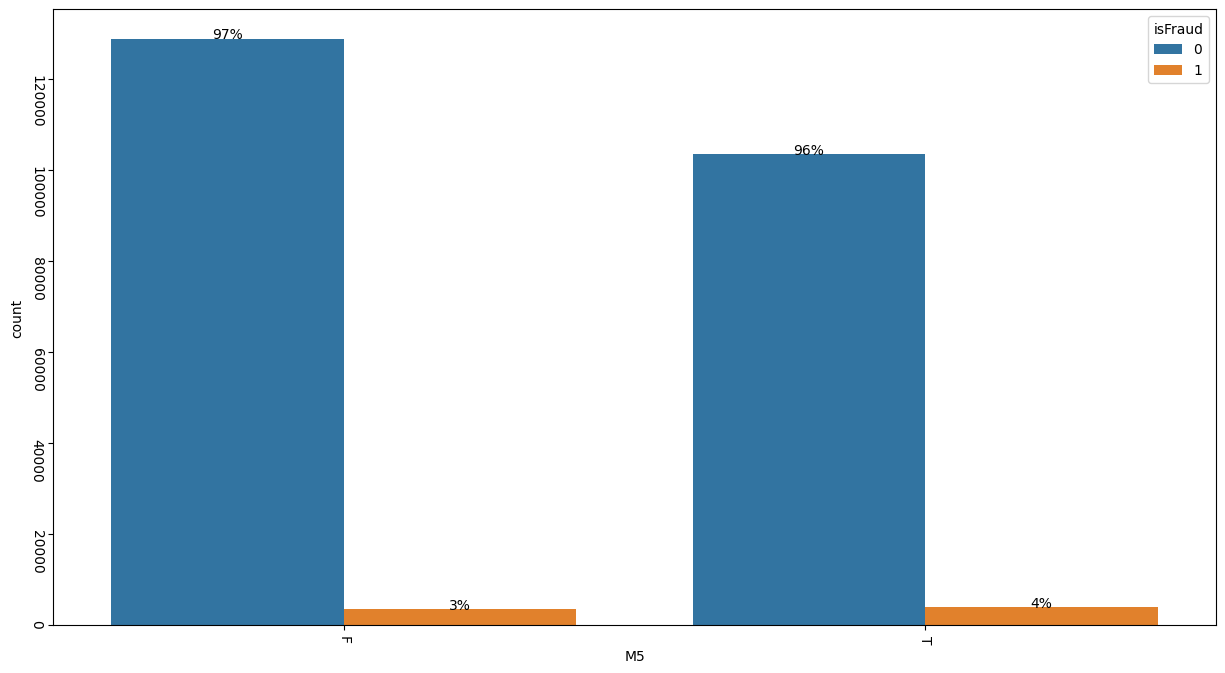

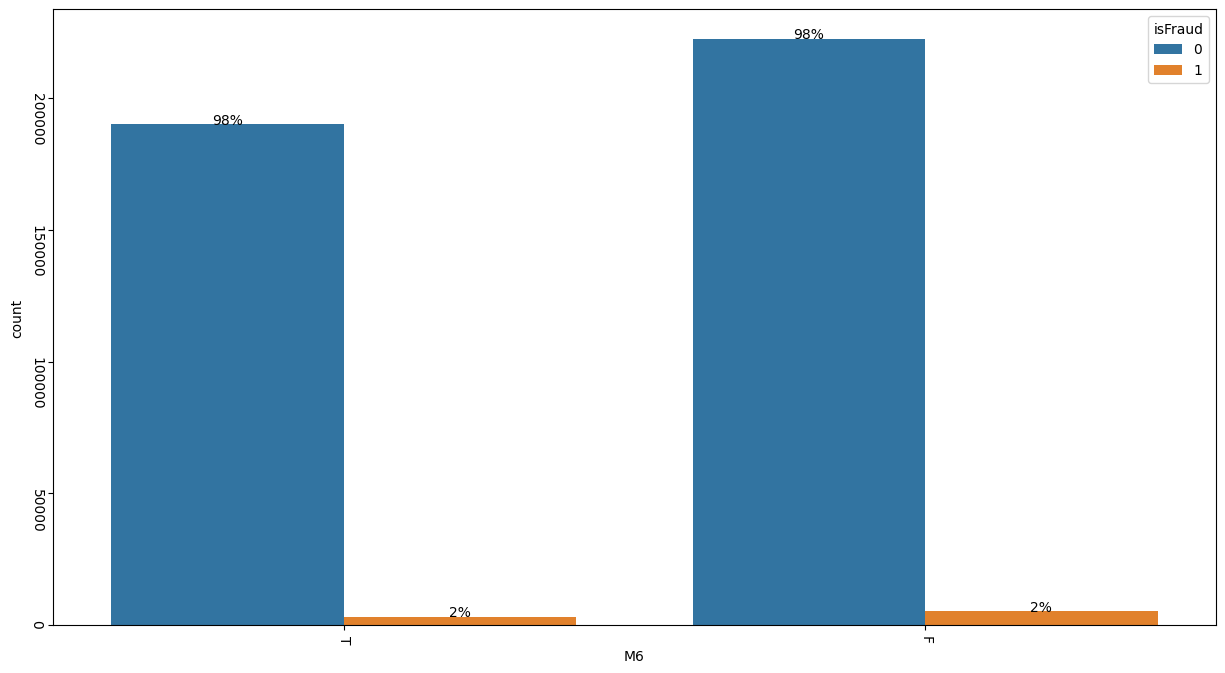

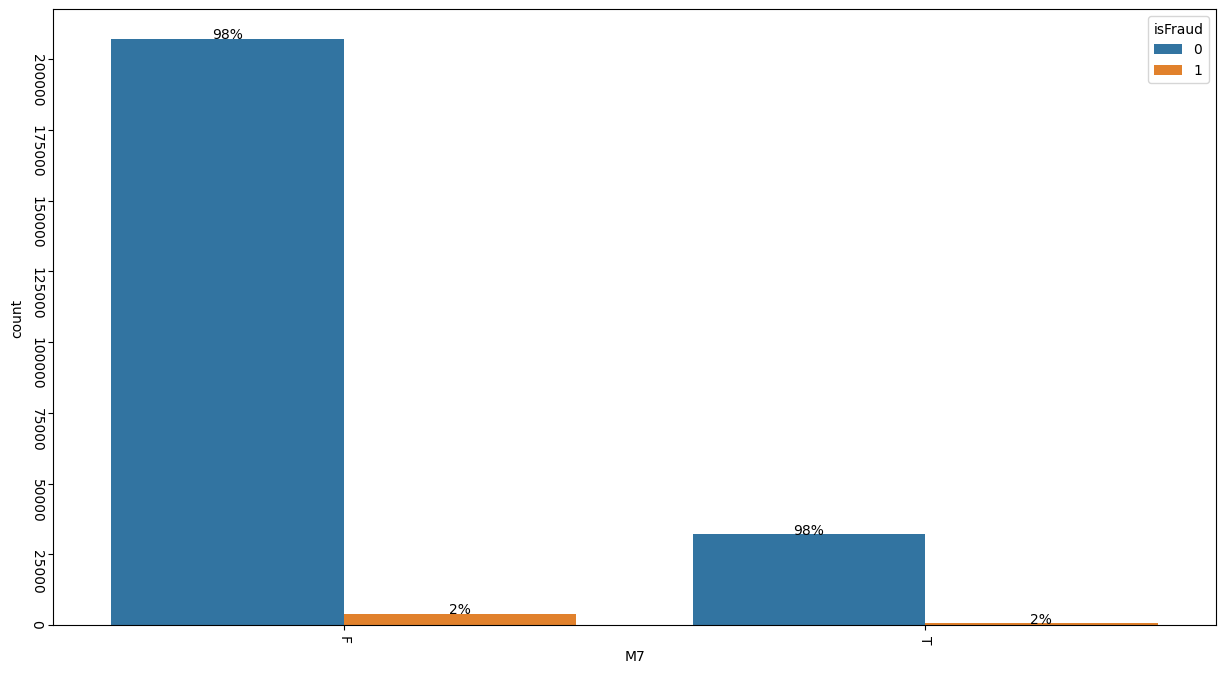

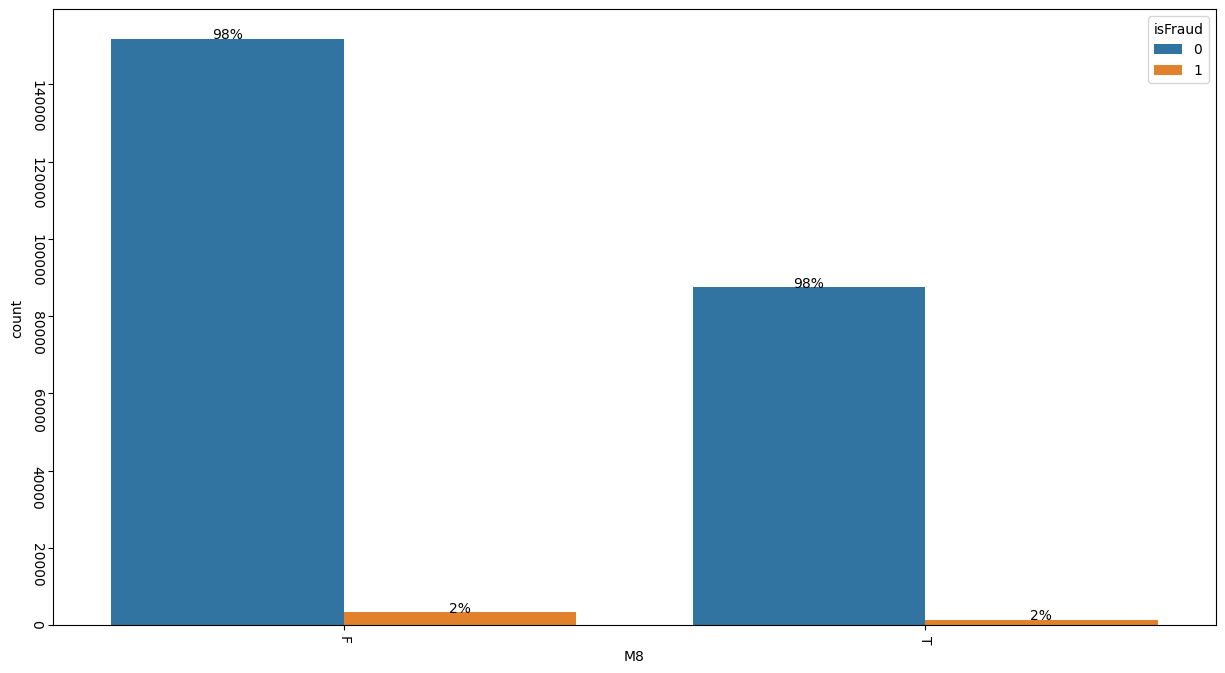

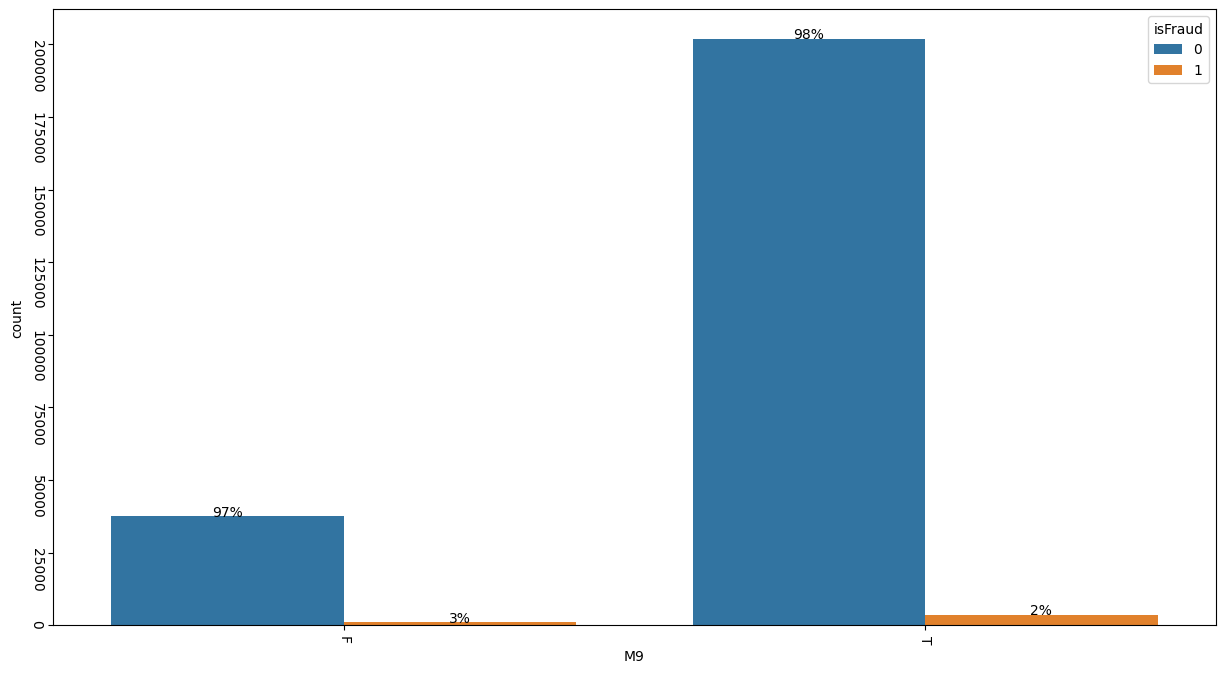

In [39]:

for idx in range(1,10):
    Plot_Cate_Correlation(train_set, col_A='M' + str(idx), col_B='isFraud',is_percentage=True)

## M1—M9

we can confirm that M1—M9 all have limited values, and the proporation gap of isFraud is relatively large in feature M4 

# id_12——id_38

In [27]:
print(cate_col_list,end = None)

['ProductCD', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 'addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
